# Classification Predict Student Solution

© Explore Data Science Academy

---
### Honour Code

I {**YOUR NAME, YOUR SURNAME**}, confirm - by submitting this document - that the solutions in this notebook are a result of my own work and that I abide by the [EDSA honour code](https://drive.google.com/file/d/1QDCjGZJ8-FmJE3bZdIQNwnJyQKPhHZBn/view?usp=sharing).

Non-compliance with the honour code constitutes a material breach of contract.

### Predict Overview: Twitter Sentiment Classification

- INSERT THIS SECTION

<a id="cont"></a>

## Table of Contents

<a href=#one>1. Importing Packages</a>

<a href=#two>2. Loading Data</a>

<a href=#three>3. Exploratory Data Analysis (EDA)</a>

<a href=#four>4. Data Engineering</a>

<a href=#five>5. Modeling</a>

<a href=#six>6. Model Performance</a>

<a href=#seven>7. Model Explanations</a>

 <a id="one"></a>
## 1. Importing Packages
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Importing Packages ⚡ |
| :--------------------------- |
| In this section we will import, and briefly discuss, the libraries that will be used throughout your analysis and modelling. |

---

First, we include a list of packages that may need to be installed on your system:

In [18]:
!pip install wordcloud
!pip install contractions
!pip install catboost
!pip install xgboost
!pip install comet_ml


Next, we import all necessary modules:

In [19]:
'''Libraries for data loading, data manipulation and data visulisation'''
# Import Numpy and Pandas for Data loading and manipulation
import pandas as pd
import numpy as np
import emoji
import regex
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report 

import string
import contractions

from comet_ml import Experiment

from scipy.sparse import hstack

import unicodedata


# Import visulisation packages
import matplotlib.pyplot as plt
import seaborn as sns
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import catboost
from catboost import CatBoostClassifier

from xgboost import XGBClassifier



# Set style for seabourn plots
sns.set_theme(style="whitegrid")



'''Libraries for data preparation and model building'''
# import 

'''Setting global constants to ensure notebook results are reproducible'''
TRAIN_TEST_SPLIT_VAR = 0.2
RAND_STATE = 42
MAX_TEXT_FEATURES = 50000

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\kobus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


<a id="two"></a>
## 2. Loading the Data
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Loading the data ⚡ |
| :--------------------------- |
| In this section we load the datasets from the files into some DataFrames. |

---

In [20]:
# Creating dataframes for the different datasets
df_train = pd.read_csv('train.csv')
df_evaluate = pd.read_csv('test_with_no_labels.csv')

<a id="three"></a>
## 3. Exploratory Data Analysis (EDA)
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Exploratory data analysis ⚡ |
| :--------------------------- |
| In this section, we will perform an in-depth analysis of all the variables in the DataFrame. |

---


Let's start with investigating the dataset by viewing how the dataframe is currently looking:

In [21]:
# Show the first 30 entries of the training dataset:
df_train.head(30)

sentiment                                            message  tweetid
0           1  PolySciMajor EPA chief doesn't think carbon di...   625221
1           1  It's not like we lack evidence of anthropogeni...   126103
2           2  RT @RawStory: Researchers say we have three ye...   698562
3           1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736
4           1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954
5           1  Worth a read whether you do or don't believe i...   425577
6           1  RT @thenation: Mike Pence doesn’t believe in g...   294933
7           1  RT @makeandmendlife: Six big things we can ALL...   992717
8           1  @AceofSpadesHQ My 8yo nephew is inconsolable. ...   664510
9           1  RT @paigetweedy: no offense… but like… how do ...   260471
10          1  RT @StephenSchlegel: she's thinking about how ...   295793
11          1  I do hope people who are vocal about climate c...   763719
12          2  RT @tveitdal: We only have a 5 percent chance ...   454673
13          1  RT @Alifaith55: Oh. My. God.\n\nTrump's Govern...    41161
14          2  Fossil fuel giant ExxonMobil ‘misled’ the publ...   658092
15          1  RT @GlblCtzn: 'I don't wanna live forever – an...   319524
16          1  RT @jackholmes0: Issues scrubbed from https://...   698009
17          1  RT @patagonia: If our elected leaders fail to ...   490604
18          1  RT @SenSanders: We have a president-elect who ...   228658
19          0  Calum: *tweets abt reunitingish w the cast*\n-...   547924
20          1  RT @c40cities: 46 C40 Mayors, representing 250...   625014
21          1  RT @World_Wildlife: How climate change impacts...   690605
22          0  we also met this guy, he let us in on some tru...    67545
23          1  https://t.co/KyNIBjmDk5\nScientists say climat...   567842
24          1  RT @TammyGrubb: Obama raises climate change. Y...   684492
25          1  I hate to say this, but *mental* health will b...   438578
26          2  Bangladesh confronting climate change head on ...   365291
27          1  Hey There! Michael's vetted and approved marke...   387685
28         -1  Sally Kohn’s latest evidence of climate change...   355491
29          1  RT @StarTalkRadio: First: The public understan...   354015

We have 3 distinct columns in the dataset: 
- `sentiment`: Which class a tweet belongs in
- `message`: Tweet body
- `tweetid`: Twitter unique id

For the purposes of our model, we wish to predict the sentiment regarding climate change of an individual, based on the message contained within their tweets. This means that our target variable is that of `sentiment`, and our predictor variable is that of `message` 

We also see that the classes that our target variable `sentiment` falls into is more than 2, which means we are not dealing with a simple binary classification problem. These classes can be described as follows:

- 2 **News**: the tweet links to factual news about climate change
- 1 **Pro**: the tweet supports the belief of man-made climate change
- 0 **Neutral**: the tweet neither supports nor refutes the belief of man-made climate change
- -1 **Anti**: the tweet does not believe in man-made climate change

Let's now look at the datatypes contained within our dataset:

In [22]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15819 entries, 0 to 15818
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  15819 non-null  int64 
 1   message    15819 non-null  object
 2   tweetid    15819 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 370.9+ KB


We note that we have a total of 15819 entries, spanning 3 columns.

We also see that both our `tweetid` and `sentiment` columns is of integer type, while our `message` column is of type string. This was to be expected, but it is always a good idea to verify! 




Let us consider if our dataset contains missing values:

In [23]:
df_train.isnull().sum()

sentiment    0
message      0
tweetid      0
dtype: int64

Luckily, we don't have any missing data. 
Let's check if our dataset contains repeating tweets:

In [24]:
duplicates = df_train[df_train[['message', 'sentiment']].duplicated(keep=False)]
duplicates.head()


sentiment                                            message  tweetid
10          1  RT @StephenSchlegel: she's thinking about how ...   295793
17          1  RT @patagonia: If our elected leaders fail to ...   490604
18          1  RT @SenSanders: We have a president-elect who ...   228658
21          1  RT @World_Wildlife: How climate change impacts...   690605
35          1  RT @BernieSanders: #ImVotingBecause the future...   817108

We see that we have 1900 entries for which the same tweet and sentiment is repeated somewhere in the dataset. Since those variables constitutes both our predictors and target variables, we should consider removing them as they add no value to the model anymore.


Now, let's look at how our data is distributed within each class in our target variable in the dataset we will be training on:

Text(0, 0.5, 'Count')

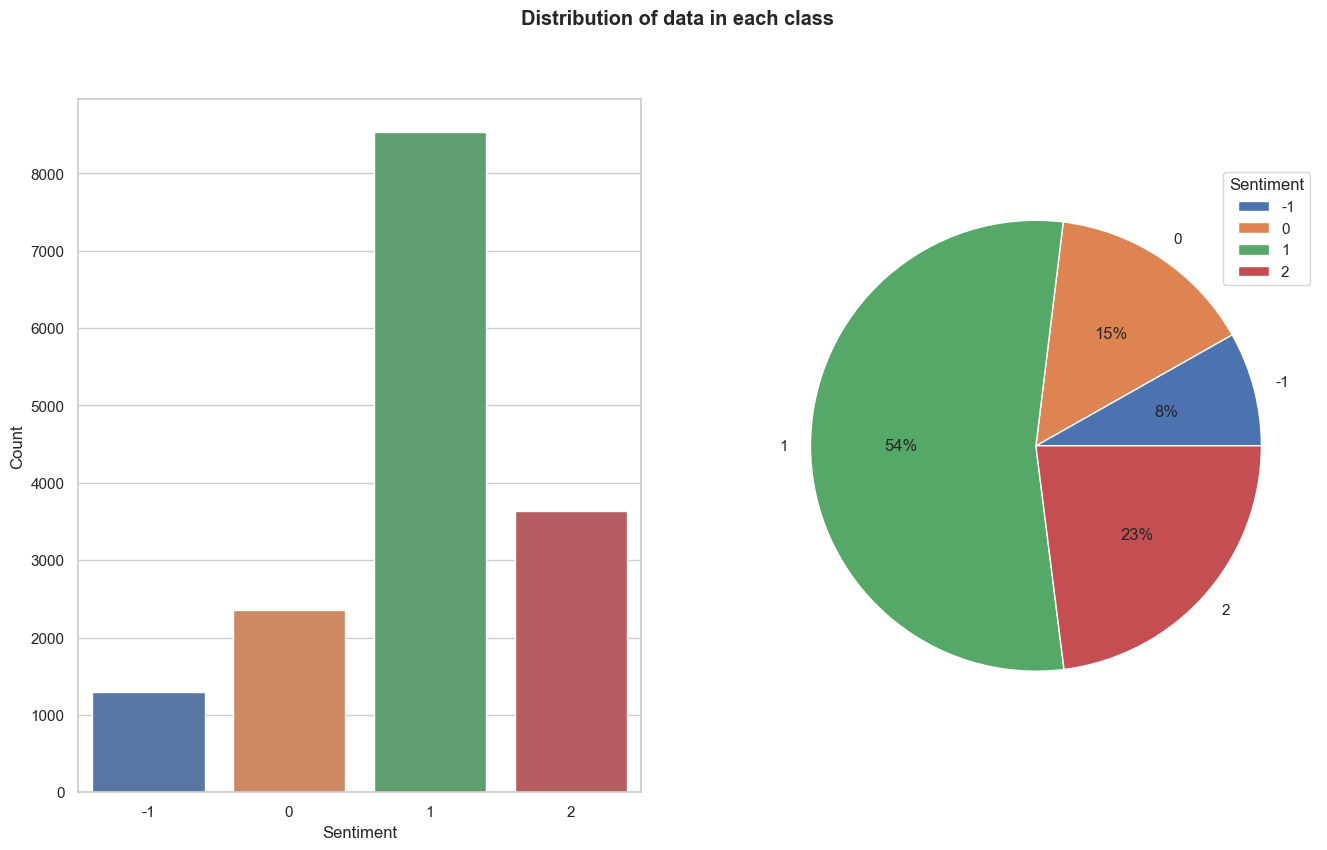

In [25]:
# Create multiple subplots
fig, axs = plt.subplots(1,2, figsize=(16,9))
# Set title of graph
fig.suptitle("Distribution of data in each class", fontweight='bold' )

# Plot 
sns.countplot(ax=axs[0], x=df_train['sentiment'])
df_train.groupby(['sentiment']).count().plot(ax=axs[1], kind = 'pie', y='message', autopct='%1.0f%%')

axs[1].set_ylabel('')
axs[1].legend(title = "Sentiment")

axs[0].set_xlabel('Sentiment')
axs[0].set_ylabel('Count')


From the figures above, we see that the dataset we are working with is very unbalanced. More than half of our dataset is people having pro-climate change sentiments, while only $ 8 \% $ of our data represents people with anti-climate change opinions. This might lead our models to become far better at identifying pro-climate change sentiment than anti-climate change sentiment, and we might need to consider balancing the data by resampling it.

Next, let us look at if any features contained within the tweets can help us identify to which sentiment the user belongs. Let's write some functions that will extract the retweets, hashtags and mentions from the tweets:

In [26]:
'''Determine if there is a retweet within the tweet'''
def is_retweet(tweet):
    word_list = tweet.split()
    if "RT" in word_list:
        return 1
    else:
        return 0

''' Function to extract retweet handles from tweet '''
def get_retweet(tweet):
    word_list = tweet.split()
    if word_list[0] == "RT":
        handle = word_list[1]
    else:
        handle = ''
        
    handle = handle.replace(':', "")

    return handle


'''Count the number of hashtags within the tweet'''
def count_hashtag(tweet):
    count = 0
    word_list = tweet.split()
    for word in word_list:
        if word[0] == '#':
            count +=1
    
    return count

'''Extract the hashtags within the tweet'''
def get_hashtag(tweet):
    hashtags = []
    word_list = tweet.split()
    for word in word_list:
        if word[0] == '#':
            hashtags.append(word)
    
    returnstr = ""
    for tag in hashtags:
        returnstr += " " + tag

    return returnstr


'''Count the number of mentions within the tweet'''
def count_mentions(tweet):
    count = 0
    word_list = tweet.split()
    if "RT" in word_list:
        count += -1 # Remove mention contained in retweet form consideration
        
    for word in word_list:
            if word[0] == '@':
                count +=1
    if count == -1:
        count = 0
    return count

'''Extract the mentions within the tweet'''
def get_mentions(tweet):
    mentions = []
    word_list = tweet.split()
    if "RT" in word_list:
        word_list.pop(1) # Retweets don't count as mentions, so we remove the retweet handle from consideration

    for word in word_list:
        if word[0] == '@':
            mentions.append(word)
    
    returnstr = ""
    for handle in mentions:
        returnstr += " " + handle

    return returnstr

Let's investigate how these features differ between classes. First, let's start by creating a copy of our data:

In [27]:
df_eda = df_train

Now, let's create some new columns containing the retweets, mentions and hashtags we wish to extract:

In [28]:
# Get retweet status and handle
df_eda["is_retweet"] = df_eda["message"].apply(is_retweet, 1)
df_eda["retweet_handle"] =  df_eda["message"].apply(get_retweet, 1)

# Get hashtag count and extract hashtags
df_eda["hashtag_count"] = df_eda["message"].apply(count_hashtag, 1)
df_eda["hashtags"] =  df_eda["message"].apply(get_hashtag, 1)

# Get mention count and extract mentions
df_eda["mention_count"] = df_eda["message"].apply(count_mentions, 1)
df_eda["mentions"] =  df_eda["message"].apply(get_mentions, 1)

# Print first 30 entries of new dataframe to validate that features were added correctly
df_eda.head(20)

sentiment                                            message  tweetid  \
0           1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1           1  It's not like we lack evidence of anthropogeni...   126103   
2           2  RT @RawStory: Researchers say we have three ye...   698562   
3           1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4           1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   
5           1  Worth a read whether you do or don't believe i...   425577   
6           1  RT @thenation: Mike Pence doesn’t believe in g...   294933   
7           1  RT @makeandmendlife: Six big things we can ALL...   992717   
8           1  @AceofSpadesHQ My 8yo nephew is inconsolable. ...   664510   
9           1  RT @paigetweedy: no offense… but like… how do ...   260471   
10          1  RT @StephenSchlegel: she's thinking about how ...   295793   
11          1  I do hope people who are vocal about climate c...   763719   
12          2  RT @tveitdal: We only have a 5 percent chance ...   454673   
13          1  RT @Alifaith55: Oh. My. God.\n\nTrump's Govern...    41161   
14          2  Fossil fuel giant ExxonMobil ‘misled’ the publ...   658092   
15          1  RT @GlblCtzn: 'I don't wanna live forever – an...   319524   
16          1  RT @jackholmes0: Issues scrubbed from https://...   698009   
17          1  RT @patagonia: If our elected leaders fail to ...   490604   
18          1  RT @SenSanders: We have a president-elect who ...   228658   
19          0  Calum: *tweets abt reunitingish w the cast*\n-...   547924   

    is_retweet    retweet_handle  hashtag_count         hashtags  \
0            0                                0                    
1            0                                0                    
2            1         @RawStory              0                    
3            0                                1   #TodayinMaker#   
4            1  @SoyNovioDeTodas              1   #ElectionNight   
5            0                                0                    
6            1        @thenation              0                    
7            1  @makeandmendlife              0                    
8            0                                0                    
9            1      @paigetweedy              0                    
10           1  @StephenSchlegel              0                    
11           0                                0                    
12           1         @tveitdal              0                    
13           1       @Alifaith55              1    #climatemarch   
14           0                                0                    
15           1         @GlblCtzn              0                    
16           1      @jackholmes0              0                    
17           1        @patagonia              0                    
18           1       @SenSanders              0                    
19           0                                0                    

    mention_count                    mentions  
0               1                   @mashable  
1               0                              
2               0                              
3               0                              
4               0                              
5               0                              
6               0                              
7               0                              
8               1              @AceofSpadesHQ  
9               0                              
10              0                              
11              1                 @GoodEnergy  
12              0                              
13              0                              
14              0                              
15              2   @taylorswift13 @zaynmalik  
16              0                              
17              0                              
18              0                            

By using the above functions, we have added a lot of features to the dataset which can be investigated. First, let's consider how many of our data entries is retweets compared to original tweets:

Text(0.5, 1.0, 'Proportion of Original Mentions')

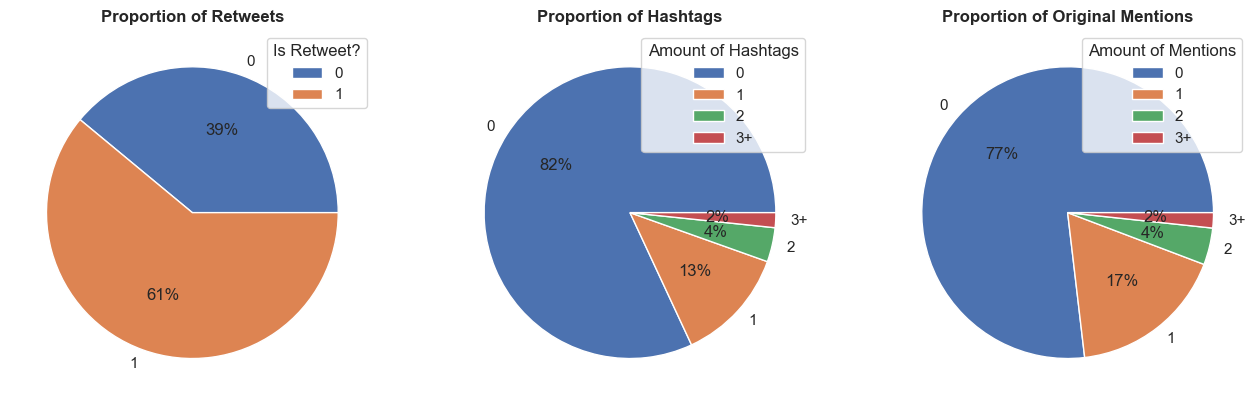

In [29]:
# Create a subset of figures
fig, axs = plt.subplots(1,3, figsize=(16,9))

# Plot pie graph showing retweet distribution
df_eda.groupby(['is_retweet']).count().plot( ax = axs[0], kind = 'pie', y='message', autopct='%1.0f%%' )
axs[0].set_ylabel('')
axs[0].legend(title = "Is Retweet?")
axs[0].set_title("Proportion of Retweets", fontweight = 'bold')


# Function to make hashtag and mention count neat for pie chart
def modify_count(count):
    if count >=3:
        return "3+"
    else:
        return str(count)

# Apply function for hashtags:
df_eda['pretty_plot_hashtag'] = df_eda["hashtag_count"].apply(modify_count, 1)

# Apply function for mentions
df_eda['pretty_plot_mention'] = df_eda["mention_count"].apply(modify_count, 1)

# Plot pie graph showing hashtag distribution
df_eda.groupby(['pretty_plot_hashtag']).count().plot( ax = axs[1], kind = 'pie', y='message', autopct='%1.0f%%' )
axs[1].set_ylabel('')
axs[1].legend(title = "Amount of Hashtags")
axs[1].set_title("Proportion of Hashtags", fontweight = 'bold')

# Plot pie graph showing mention distribution
df_eda.groupby(['pretty_plot_mention']).count().plot( ax = axs[2], kind = 'pie', y='message', autopct='%1.0f%%' )
axs[2].set_ylabel('')
axs[2].legend(title = "Amount of Mentions")
axs[2].set_title("Proportion of Original Mentions", fontweight = 'bold')

We see that a staggering $60\%$ of all our data is not original tweets, but retweets! This indicates that extracting more information from the retweets could prove integral to optimizing our model's predictive capabilities. 

Furthermore, we see that $82\%$ of our data contains no hashtags. While the hashtags that is being used could still provide a great starting point for the model, most of the data does not contain hashtags and as such, this feature might prove less useful than one might hope. 

Lastly, let's consider the mentions. For our purposes, we only look at original mentions, meaning that we don't consider handles that gets retweeted to count towards the total. We see that even though the majority of data does not contain original mentions, there still exist a substantial amount within our data, and will therefore be important to consider within our model.

Let's break the above statistics down by category, to see if there exist certain trends within the sentiment groups that could help us with identifying them: 

Text(0.5, 1.0, 'Average Mentions per Tweet per Sentiment Group')

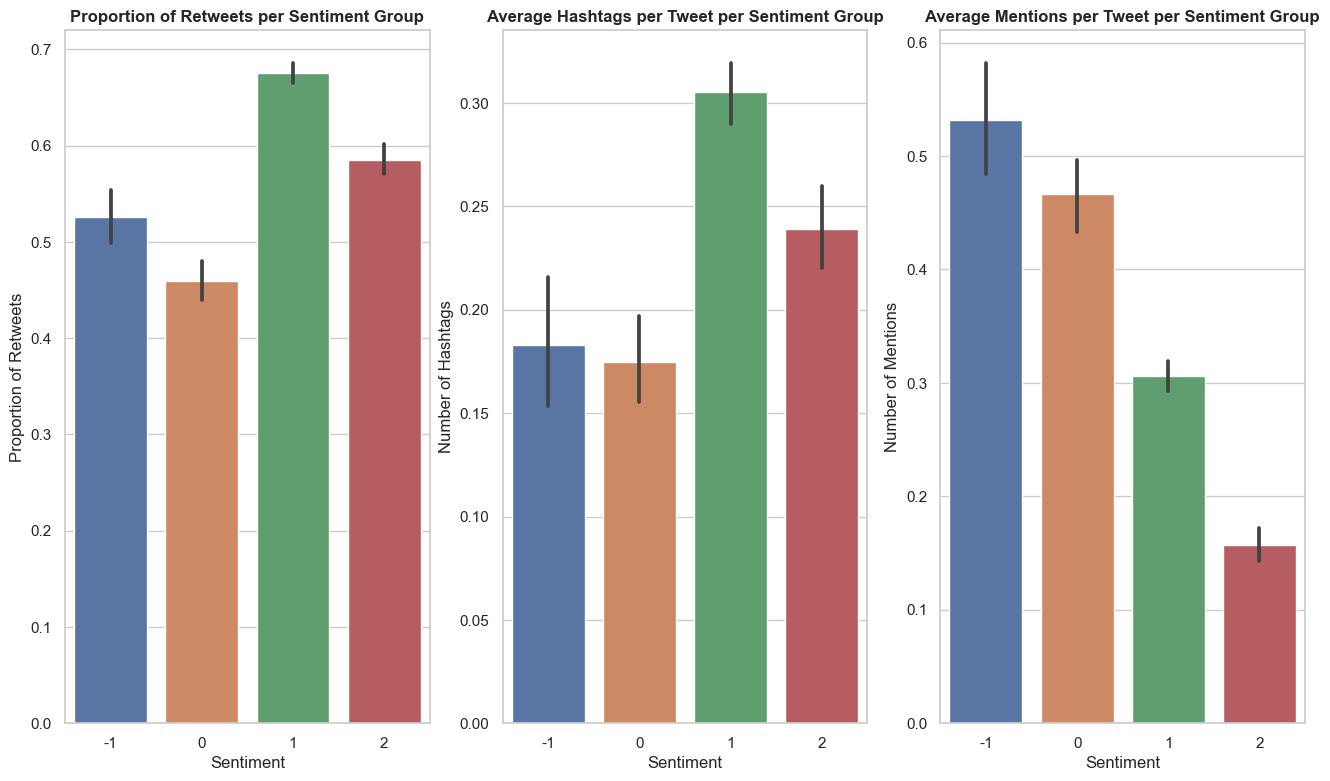

In [30]:
# Create a grid of figures
fig, axs = plt.subplots(1,3,figsize=(16,9))

# Plot retweet distribution
sns.barplot(ax = axs[0] ,data=df_eda, x="sentiment", y="is_retweet")
axs[0].set_ylabel('Proportion of Retweets')
axs[0].set_xlabel("Sentiment")
axs[0].set_title("Proportion of Retweets per Sentiment Group", fontweight = 'bold')

# Plot hashtag distribution
sns.barplot(ax = axs[1] ,data=df_eda, x="sentiment", y="hashtag_count")
axs[1].set_ylabel('Number of Hashtags')
axs[1].set_xlabel("Sentiment")
axs[1].set_title("Average Hashtags per Tweet per Sentiment Group", fontweight = 'bold')

# Plot mentions distribution
sns.barplot(ax = axs[2] ,data=df_eda, x="sentiment", y="mention_count")
axs[2].set_ylabel('Number of Mentions')
axs[2].set_xlabel("Sentiment")
axs[2].set_title("Average Mentions per Tweet per Sentiment Group", fontweight = 'bold')


First, let us consider the proportion of tweets that are retweets for each individual sentiment. We see that in our dataset, the people with a pro-climate change outlook has the highest proportion of retweets of any group, with news tweets from the media coming in a close second. Even though the differences between these categories isn't that big, it still captures a substantial effect, and it would be beneficial to include retweets within the model. 

Next, we consider the average number of hashtags contained within the tweets. Here, we find a vast difference between certain categories. Once again, the group expressing pro-climate change sentimentalities uses the most number of hashtags, followed closely by factual news tweets. The neutral and anti-climate change categories are far less likely to use hashtags in their tweets, since they use fewer hashtags on average

Finally, we consider the amount of original mentions for each group. Remember, we define _original mentions_ to be any mentions contained within tweets after the retweet handle was removed, i.e. it refers to mentions within tweets, but disregards retweet handles from the list. Here, we see a surprising trend. The anti-climate change group uses the most amount of mentions per tweet- substantially more than the pro-climate change group and more than double that of the factual news tweets. 

All of the features above identify valuable differences between the classes, and as such, should be included within the model.

Let's break it down a bit further, and dive deeper into the most popular retweets, hashtags and mentions per category. First, let's manipulate the data into a more usable form in order to help us draw word clouds. First, we split our dataframe into multiple dataframes based on the sentiment we wish to investigate:

In [31]:
# Filter Anti-Climate change sentiment
df_eda_anti = df_eda[df_eda["sentiment"] ==  -1]
# Filter neutral sentiment
df_eda_neutral = df_eda[df_eda["sentiment"] ==  0]
# Filter Pro-Climate change sentiment
df_eda_pro = df_eda[df_eda["sentiment"] ==  1]
# Filter factual news sentiment
df_eda_news = df_eda[df_eda["sentiment"] ==  2]


_The following cell might take some time to run (~3 mins). Creating wordclouds is timely :)_

We start with looking at the most common retweeted handles for each category: 

(-0.5, 1599.5, 1599.5, -0.5)

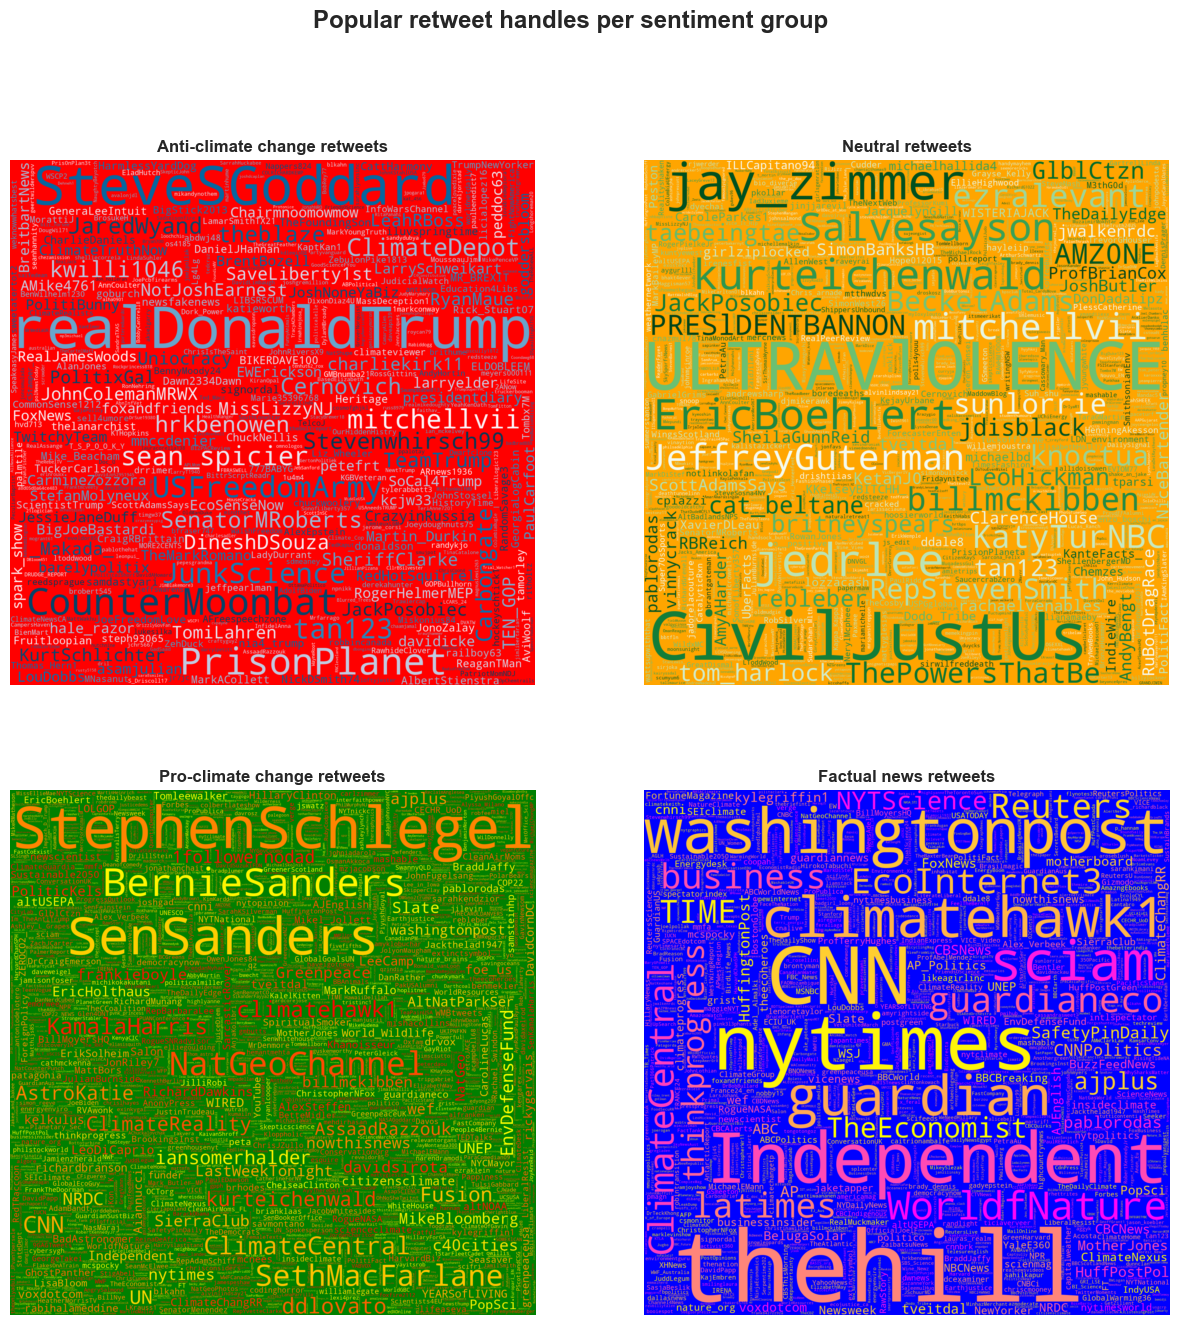

In [32]:
# Create word strings containing retweet handles for each sentiment
word_string_anti=" ".join(df_eda_anti['retweet_handle'])
word_string_neutral=" ".join(df_eda_neutral['retweet_handle'])
word_string_pro=" ".join(df_eda_pro['retweet_handle'])
word_string_news=" ".join(df_eda_news['retweet_handle'])

# Create a new figure
plt.figure(figsize=(15,15))

plt.suptitle("Popular retweet handles per sentiment group", fontweight='bold', fontsize = "x-large")
# Plot anti-climate change sentiments
plt.subplot(2,2,1).set_title("Anti-climate change retweets", fontweight = 'bold')
wc = WordCloud(background_color="red", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_anti)
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot neutral sentiments
plt.subplot(2,2,2).set_title("Neutral retweets", fontweight = 'bold')
wc = WordCloud(background_color="orange", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_neutral)
plt.imshow(wc.recolor( colormap= 'Greens' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,3).set_title("Pro-climate change retweets", fontweight = 'bold')
wc = WordCloud(background_color="green", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_pro)
plt.imshow(wc.recolor( colormap= 'autumn' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,4).set_title("Factual news retweets", fontweight = 'bold')
wc = WordCloud(background_color="blue", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_news)
plt.imshow(wc.recolor( colormap= 'spring' , random_state=17), interpolation="bilinear")
plt.axis('off')

From the above, we see a clear difference between every sentiment with regards to who they are retweeting. This is great news, since it will provide an excellent feature within our model. Little overlap between categories is visible, which points to the fact that this feature could be a very strong predictor.

We see that people with anti-climate change sentiments retweets from users like `@realDonaldTrump` and `@SteveSGoddard` the most. Overall retweets associated with anti-climate science opinions are frequently sourced from prominent Republican figures such as Donald Trump, along with individuals who identify as climate change deniers, like Steve Goddard.

In contrast to this, people with pro-climate change views often retweet Democratic political figures such as `@SenSanders` and `@KamalaHarris`. Along with this, we see a trend to retweet comedians like `@SethMacFarlane`. The most retweeted individual for this category, is `@StephenSchlegel`. 

Retweets in the factual news category mostly contains handles of media news organizations, like `@thehill`, `@CNN`, `@wasgingtonpost` etc...

People with neutral sentiments regarding climate change seems to not retweet overtly political figures. Instead, they retweet handles unknown to the writer like `@CivilJustUs` and `@ULTRAVIOLENCE` which no longer currently exist on twitter. The comedian `@jay_zimmer` is also a common retweeted incividual within this category.

By repeating the steps above, we can now turn our attention to the different hashtags popular within each category:

(-0.5, 1599.5, 1599.5, -0.5)

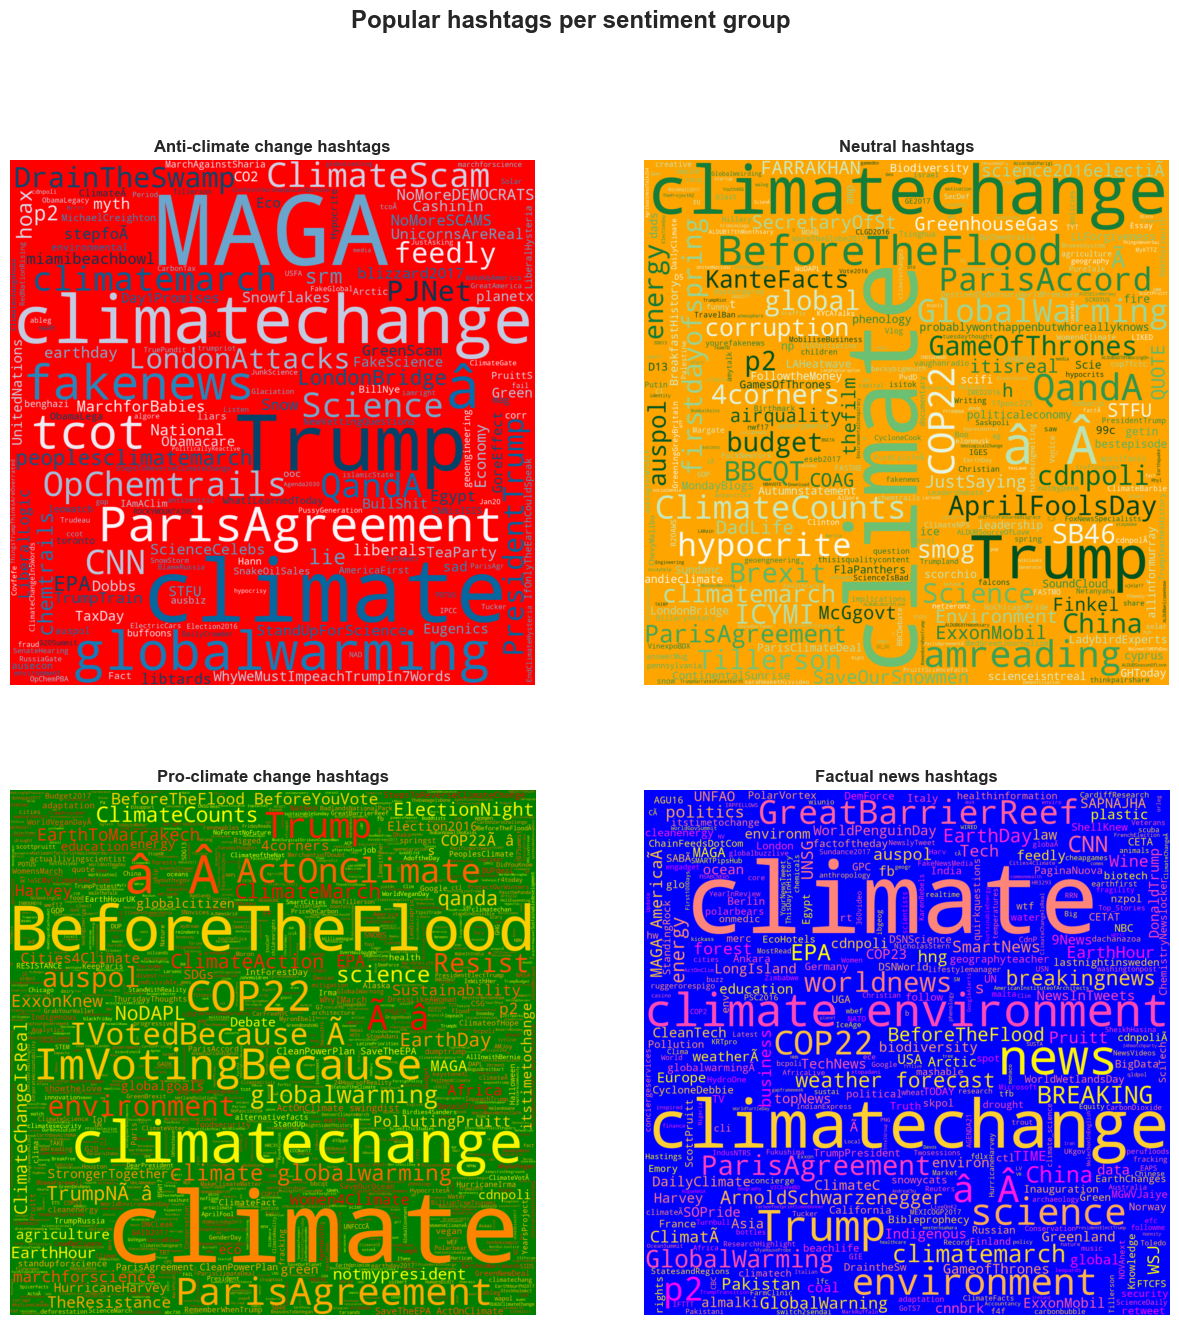

In [33]:
# Create word strings containing retweet handles for each sentiment
word_string_anti=" ".join(df_eda_anti['hashtags'])
word_string_neutral=" ".join(df_eda_neutral['hashtags'])
word_string_pro=" ".join(df_eda_pro['hashtags'])
word_string_news=" ".join(df_eda_news['hashtags'])

# Create a new figure
plt.figure(figsize=(15,15))
plt.suptitle("Popular hashtags per sentiment group", fontweight='bold', fontsize = "x-large")

# Plot anti-climate change sentiments
plt.subplot(2,2,1).set_title("Anti-climate change hashtags", fontweight = 'bold')
wc = WordCloud(background_color="red", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_anti)
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot neutral sentiments
plt.subplot(2,2,2).set_title("Neutral hashtags", fontweight = 'bold')
wc = WordCloud(background_color="orange", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_neutral)
plt.imshow(wc.recolor( colormap= 'Greens' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,3).set_title("Pro-climate change hashtags", fontweight = 'bold')
wc = WordCloud(background_color="green", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_pro)
plt.imshow(wc.recolor( colormap= 'autumn' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,4).set_title("Factual news hashtags", fontweight = 'bold')
wc = WordCloud(background_color="blue", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_news)
plt.imshow(wc.recolor( colormap= 'spring' , random_state=17), interpolation="bilinear")
plt.axis('off')

From the visual above, we notice a few things:

First of all, there is some strange characters in our data, like `#Ã â` and `#â Â` for example. This is considered noise, and will need to be removed before training our models. 

We see that a lot of hashtags are common in every sentiment category. Hashtags like `#climatechange`, `#cllimate` and `#Trump` is abundant regardless of which category is considered, and can therefore be removed from the list of hashtags since they won't contribute any meaningful insight to our models. 

Finally there is some hashtags that are more prominent within certain sentiment groups. Take `#MAGA` and `#fakenews` in the anti-climate change category, or `#ImVotingBecause` in the pro-climate change category. This indicates that some useful information can be extracted from this feature, and should remain within the model.

Let's repeat the process one last time in order to investigate the original mentions in each category

(-0.5, 1599.5, 1599.5, -0.5)

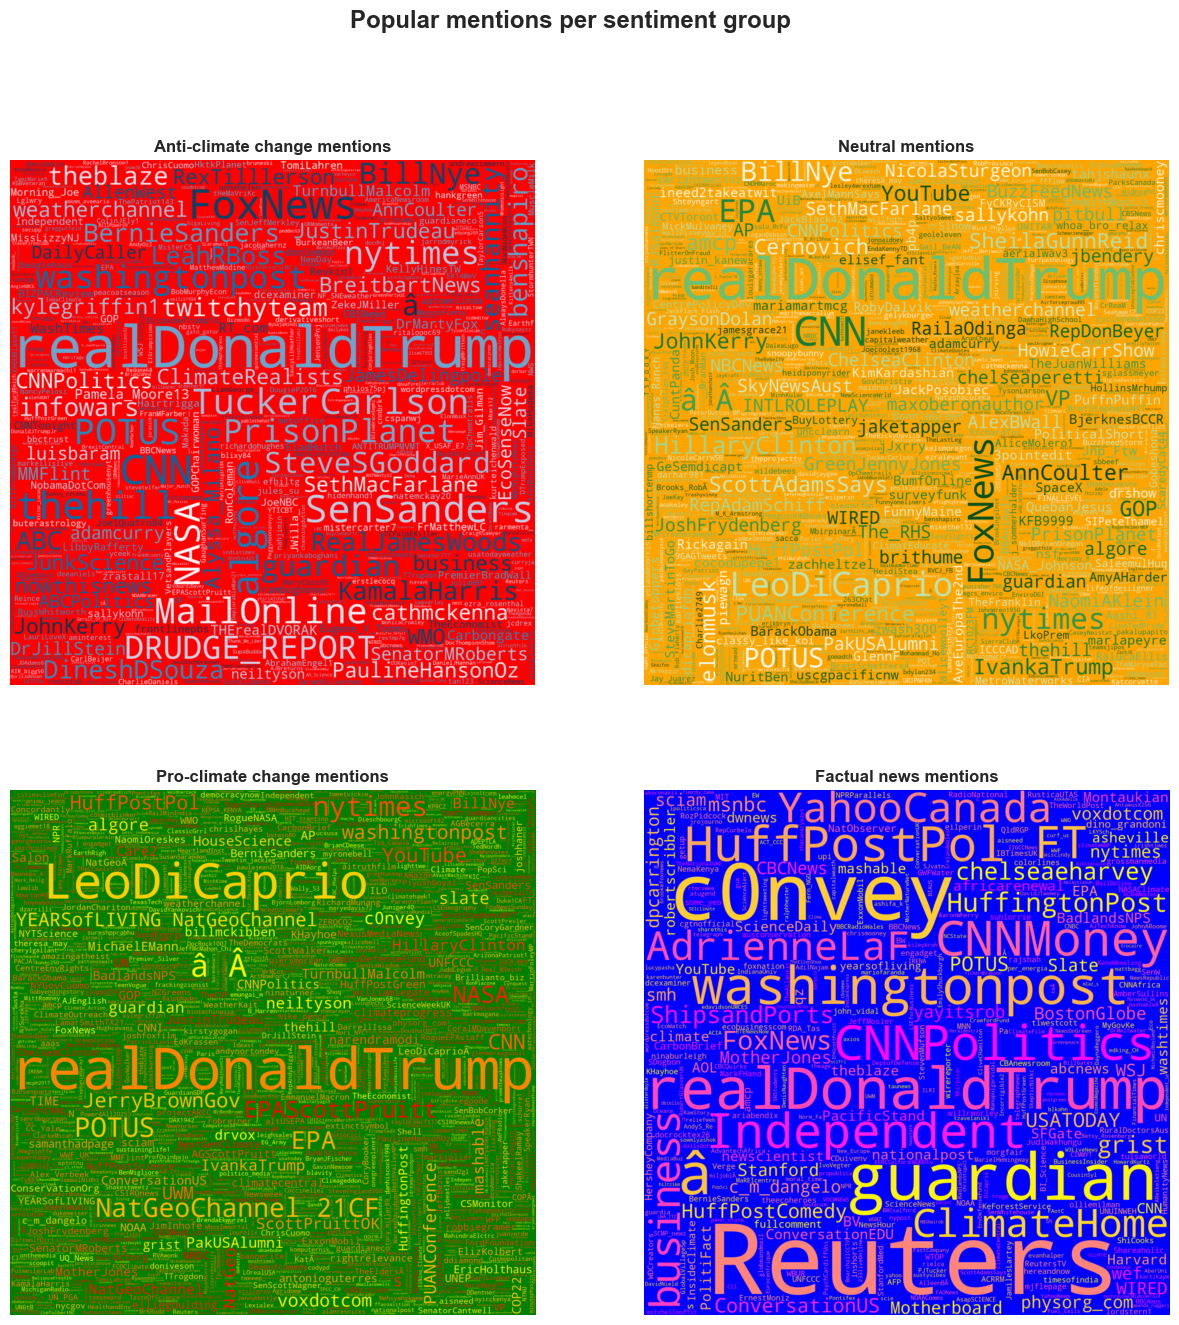

In [34]:
# Create word strings containing retweet handles for each sentiment
word_string_anti=" ".join(df_eda_anti['mentions'])
word_string_neutral=" ".join(df_eda_neutral['mentions'])
word_string_pro=" ".join(df_eda_pro['mentions'])
word_string_news=" ".join(df_eda_news['mentions'])

# Create a new figure
plt.figure(figsize=(15,15))
plt.suptitle("Popular mentions per sentiment group", fontweight='bold', fontsize = "x-large")

# Plot anti-climate change sentiments
plt.subplot(2,2,1).set_title("Anti-climate change mentions", fontweight = 'bold')
wc = WordCloud(background_color="red", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_anti)
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot neutral sentiments
plt.subplot(2,2,2).set_title("Neutral mentions", fontweight = 'bold')
wc = WordCloud(background_color="orange", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_neutral)
plt.imshow(wc.recolor( colormap= 'Greens' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,3).set_title("Pro-climate change mentions", fontweight = 'bold')
wc = WordCloud(background_color="green", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_pro)
plt.imshow(wc.recolor( colormap= 'autumn' , random_state=17), interpolation="bilinear")
plt.axis('off')

# Plot pro-climate change sentiments
plt.subplot(2,2,4).set_title("Factual news mentions", fontweight = 'bold')
wc = WordCloud(background_color="blue", max_words=2000, max_font_size= 300,  width=1600, height=1600)
wc.generate(word_string_news)
plt.imshow(wc.recolor( colormap= 'spring' , random_state=17), interpolation="bilinear")
plt.axis('off')

As was the case when we considered hashtags, we see that some handles get mentioned regardless of sentiment class. An example of this is `@realDonaldTrump`, which is prominent in every sentiment category, and as such should be removed before training our models, since it adds no value towards our data. 

Furthermore, there is some mentions that are more prominent in certain classes than others. Take `@LeoDiCaprio` for example, which features heavily in both pro-climate change as well as neutral towards climate change sentiment, but is not represented in the other two categories. This indicates that this feature could be beneficial for categorizing our data, and should remain within the dataset





Let's investigate if there exist more features that could help identify the category a tweet belongs to.

 Looking at our data, we see that a lot of tweets contains links to external websites in the form of _https://t.somecharactershere_. It is very difficult to extract the context of the website in this form, since it is only a collection of random characters. We can however count the amount of websites within each tweet, and try to use that as a metric.

 Furthermore, we see that some tweets contain emojis. We can translate these emojis to text for when we train our model, so that it gets processed along with the words contained in the tweet. We can also count the amount of emojis within the tweet, and attempt to use that as a metric. 

 Some of the tweets in our dataset also has some newline characters within, changing how the tweet is presented on the website. We could also attempt to use this as a metric for our models, by counting the amount of newlines within each tweet. 

 Lastly, we can attempt to quantify the emotions within a tweet by checking if swear words are present within a tweet, as well as the amount of exclamation marks the tweet contains. To consider the amount of swear words, we make use of _The Obscenity List_, compiled by surge AI available [here](https://github.com/surge-ai/profanity)

 We can make some functions to do the above, which we can apply to our data:

In [35]:
# Count number of web links within tweet
def count_links(tweet):
    count = tweet.count("https:")
    return count

# Count number of emojis within tweet:
def count_emoji(tweet):
    emoji_counter = emoji.emoji_count(tweet)
    return emoji_counter


# Count number of newlines within tweet:
def enter_count(tweet):
    count = tweet.count('\n')
    return count


# Count number of exclamation marks within tweet:
def exclamation_count(tweet):
    count = tweet.count('!')
    return count

# Create a list of curse words contained in the accompanying csv file

df_cursewords = pd.read_csv("profanity_en.csv")
cursewords = list(df_cursewords.text)


# Count number of profanities in tweet:
def curse_count(tweet):
    count = 0
    tweet = tweet.lower()
    wordlist = tweet.split()
    for word in wordlist:
        if word in cursewords:
            count += 1

    return count



Lets create the new features by applying the functions above to our dataset: _(Looking through all the text for profanity might take a minute or two)_

In [36]:
# Get number of links
df_eda["link_count"] = df_eda["message"].apply(count_links, 1)

# Get number of emojis
df_eda["emoji_count"] = df_eda["message"].apply(count_emoji, 1)

# Get number of newlines
df_eda["newline_count"] = df_eda["message"].apply(enter_count, 1)

# Get number of exclamation marks
df_eda["exclamation_count"] =  df_eda["message"].apply(exclamation_count, 1)

# Check if tweet contains profanity:
df_eda["profanity_count"] = df_eda["message"].apply(curse_count, 1)

#check that new features were created
df_eda.head(10)

sentiment                                            message  tweetid  \
0          1  PolySciMajor EPA chief doesn't think carbon di...   625221   
1          1  It's not like we lack evidence of anthropogeni...   126103   
2          2  RT @RawStory: Researchers say we have three ye...   698562   
3          1  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4          1  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   
5          1  Worth a read whether you do or don't believe i...   425577   
6          1  RT @thenation: Mike Pence doesn’t believe in g...   294933   
7          1  RT @makeandmendlife: Six big things we can ALL...   992717   
8          1  @AceofSpadesHQ My 8yo nephew is inconsolable. ...   664510   
9          1  RT @paigetweedy: no offense… but like… how do ...   260471   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   
5           0                                0                    
6           1        @thenation              0                    
7           1  @makeandmendlife              0                    
8           0                                0                    
9           1      @paigetweedy              0                    

   mention_count         mentions pretty_plot_hashtag pretty_plot_mention  \
0              1        @mashable                   0                   1   
1              0                                    0                   0   
2              0                                    0                   0   
3              0                                    1                   0   
4              0                                    1                   0   
5              0                                    0                   0   
6              0                                    0                   0   
7              0                                    0                   0   
8              1   @AceofSpadesHQ                   0                   1   
9              0                                    0                   0   

   link_count  emoji_count  newline_count  exclamation_count  profanity_count  
0           1            0              0                  1                0  
1           0            0              0                  0                0  
2           2            0              0                  0                0  
3           1            0              0                  0                0  
4           0            0              0                  0                0  
5           2            0              0                  0                0  
6           1            0              0                  0                0  
7           1            0              0                  0                0  
8           0            0              0                  0                0  
9           0            0              0                  0                0

Let's break these newly created features down by sentiment, to see if they could provide some insights into our data:

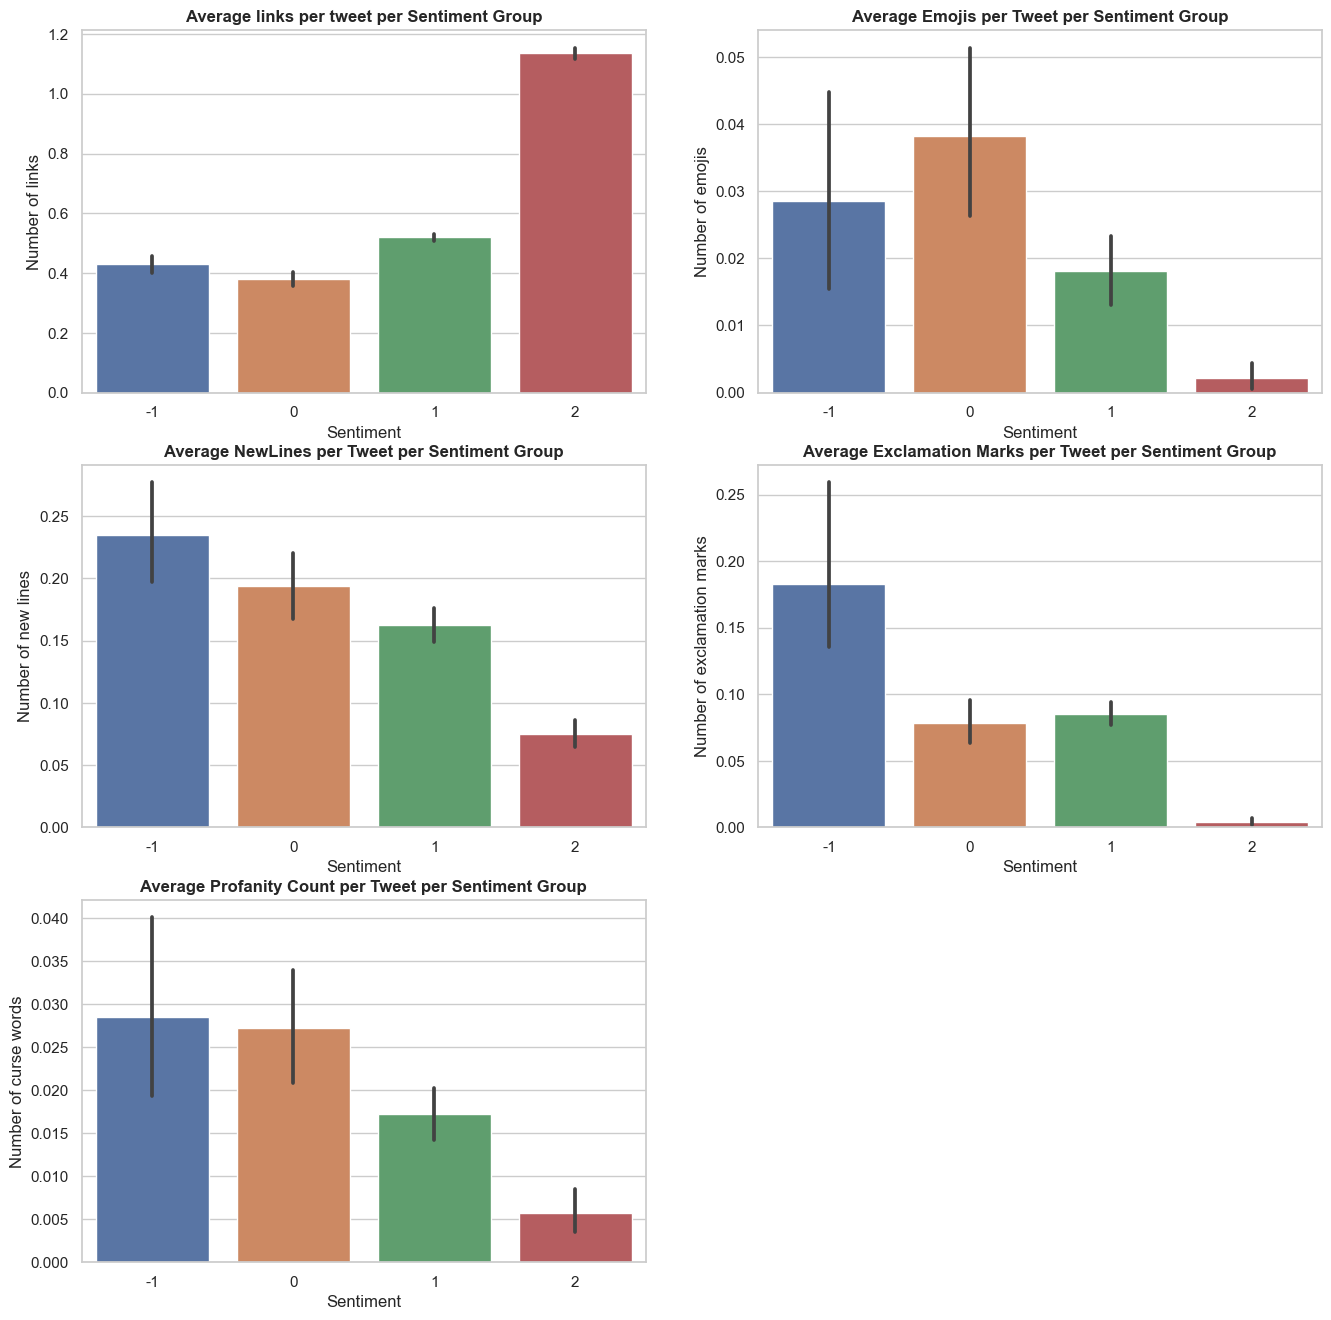

In [37]:
fig, axs = plt.subplots( 3, 2, figsize=(16,16))

# Plot link distribution
sns.barplot(ax = axs[0][0] , data=df_eda, x="sentiment", y="link_count")
axs[0][0].set_ylabel('Number of links')
axs[0][0].set_xlabel("Sentiment")
axs[0][0].set_title("Average links per tweet per Sentiment Group", fontweight = 'bold')

# Plot emoji distribution
sns.barplot(ax = axs[0][1] , data=df_eda, x="sentiment", y="emoji_count")
axs[0][1].set_ylabel('Number of emojis')
axs[0][1].set_xlabel("Sentiment")
axs[0][1].set_title("Average Emojis per Tweet per Sentiment Group", fontweight = 'bold')

# Plot newline distribution
sns.barplot(ax = axs[1][0] , data=df_eda, x="sentiment", y="newline_count")
axs[1][0].set_ylabel('Number of new lines')
axs[1][0].set_xlabel("Sentiment")
axs[1][0].set_title("Average NewLines per Tweet per Sentiment Group", fontweight = 'bold')

# Plot exclamation mark distribution
sns.barplot(ax = axs[1][1] , data=df_eda, x="sentiment", y="exclamation_count")
axs[1][1].set_ylabel('Number of exclamation marks')
axs[1][1].set_xlabel("Sentiment")
axs[1][1].set_title("Average Exclamation Marks per Tweet per Sentiment Group", fontweight = 'bold')

# Plot profanity distribution
sns.barplot(ax = axs[2][0] , data=df_eda, x="sentiment", y="profanity_count")
axs[2][0].set_ylabel('Number of curse words')
axs[2][0].set_xlabel("Sentiment")
axs[2][0].set_title("Average Profanity Count per Tweet per Sentiment Group", fontweight = 'bold')

axs[2][1].set_axis_off()

The image above contains a lot of information about our data. Let's break it down by feature.

First, we consider the average amount of links per tweet. We see that tweets containing factual news about climate change in our dataset contains a lot more links on average than any other category in the data. Within the other categories, not much variation exist when considering this feature. This feature might help us to predict factual news tweets, and as such, should be used when building our models.

Next, we look at the amount of emojis per tweet. We see that factual news tweets contains very little emojis, while people with neutral sentiments use the most. The amount of emojis in our data is very little, however, and does not contribute to the vast majority of data. As such, we might neglect the `emoji_count` feature, and instead translate the emojis to text, which will be used by the model. 

Considering the amount of new paragraphs (or newlines) in the data, we find that people expressing anti-climate change sentiments use the newline character the most to space out their tweets, whilst the factual news tweets contains the least amount of average newlines for any sentiment group. This feature seems to contribute to the amount of information contained within the data, and should therefore be used when training our models.

A surprising feature that emerged, is that of the average amount of exclamation marks per tweet. People expressing anti-climate change sentiments use this character more that twice the amount of those possessing neutral and pro-climate change sentiments. Futhermore, factual news tweets almost never contain exclamation marks. This is an excellent feature to include when training our models

Lastly, we consider the profanity contained within tweets. As expected, factual news tweets contained the least amount of average profanity per tweet form any group. People maintaining anti-climate change views uses the most of any group, followed closely by people that are neutral to th issue of climate-change. Again, as was the case for emojis, the amount of profanity in the data is very low, and as such, we can neglect the `profanity_count` feature when training our models.


For our last consideration within the EDA, let's look at the most common words found within the dataset. First, we need to clean the data to remove some things from consideration. We start by converting all of the words to lowercase so that capitalization no longer differentiates between words:

In [38]:
# Transform tweets into lowercase versions of tweets:
def lowercase(tweet):
    return tweet.lower()
df_eda["message"] = df_eda['message'].apply(lowercase)




Next, we replace all URLs within the data with a common alias:

In [39]:
# Replace URLs within the dataframe
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_eda['message'] = df_eda['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)




Since we have already looked at retweets, mentions and hashtags, we remove them from consideration for now:

In [40]:
# Remove handles from tweet:
def remove_handles(tweet):
    wordlist = tweet.split()
    for word in wordlist:
        if word[0] == '@':
            wordlist.remove(word)
    returnstr = ''
    for word in wordlist:
        returnstr += word + " "
    return returnstr

# Remove handles from tweet:
def remove_hashtags(tweet):
    wordlist = tweet.split()
    for word in wordlist:
        if word[0] == '#':
            wordlist.remove(word)
    returnstr = ''
    for word in wordlist:
        returnstr += word + " "
    return returnstr

# Remove RT from tweet:
def remove_rt(tweet):
    wordlist = tweet.split()
    for word in wordlist:
        if word == 'rt' or word=='RT':
            wordlist.remove(word)
    returnstr = ''
    for word in wordlist:
        returnstr += word + " "
    return returnstr

Applying these functions to our dataset:

In [41]:
# Remove hashtags, handles and retweets form the data
df_eda["message"] = df_eda['message'].apply(remove_handles)
df_eda["message"] = df_eda['message'].apply(remove_hashtags)
df_eda["message"] = df_eda['message'].apply(remove_rt)

Next, we remove all common stopwords form the data, as they will not provide meaningful insights:

In [42]:
# Remove common english stop words from the data
def remove_stop_words(tweet):
    words = tweet.split()     
    return ' '.join([t for t in words if t not in stopwords.words('english')])

# Apply function to the data:
df_eda["message"] = df_eda['message'].apply(remove_stop_words)

Lastly, we remove all punctuation from the tweets, so that we are left with only words:

In [43]:
# Showing the punctuation to be removed
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [44]:
# Remove punctuation from tweets:
def remove_punctuation(tweet):
    return ''.join([l for l in tweet if l not in string.punctuation])

# Apply function to data
df_eda["message"] = df_eda['message'].apply(remove_punctuation)

Writing a function to count the amount of words present within the data:

In [45]:
def bag_of_words_count(words, word_dict={}):
    """ this function takes in a list of words and returns a dictionary 
        with each word as a key, and the value represents the number of 
        times that word appeared"""
    for word in words:
        if word in word_dict.keys():
            word_dict[word] += 1
        else:
            word_dict[word] = 1
    return word_dict

We can apply that to the data. First, let's look at the most common words over the whole dataset:

In [46]:
# Join all tweets within one string variable
all_tweets = " ".join(df_eda["message"])

# Split tweets into list of words
word_list = all_tweets.split()

# Count words in dataset
word_count = {}
bag_of_words_count(word_list, word_count)

# Sort dictionary on word count
word_count = sorted(word_count.items(), key=lambda x:x[1], reverse=True)

print(word_count)


[('climate', 12555), ('change', 12211), ('urlweb', 8028), ('global', 3761), ('warming', 3413), ('trump', 1864), ('believe', 1154), ('urlweb…', 1027), ('us', 891), ('amp', 872), ('real', 682), ('going', 670), ('world', 634), ('people', 600), ('urlwebã¢â‚¬â¦', 588), ('new', 538), ('via', 515), ('epa', 514), ('fight', 468), ('says', 429), ('like', 428), ('die', 418), ('science', 413), ('scientists', 408), ('donald', 383), ('hoax', 382), ('say', 366), ('think', 360), ('https…', 357), ('thinking', 353), ('trumps', 343), ('president', 336), ('husband', 317), ('could', 301), ('need', 299), ('one', 285), ('know', 282), ('action', 275), ('china', 270), ('make', 269), ('right', 262), ('would', 257), ('years', 253), ('thinks', 248), ('im', 246), ('news', 246), ('stop', 245), ('energy', 242), ('still', 228), ('cause', 224), ('weather', 223), ('must', 221), ('pruitt', 219), ('due', 218), ('time', 216), ('presidentelect', 213), ('chinese', 212), ('scott', 212), ('get', 211), ('want', 210), ('planet'

Let's plot the 20 most occurring words:

<AxesSubplot:title={'center':'Count of most occurring words'}, ylabel='Word'>

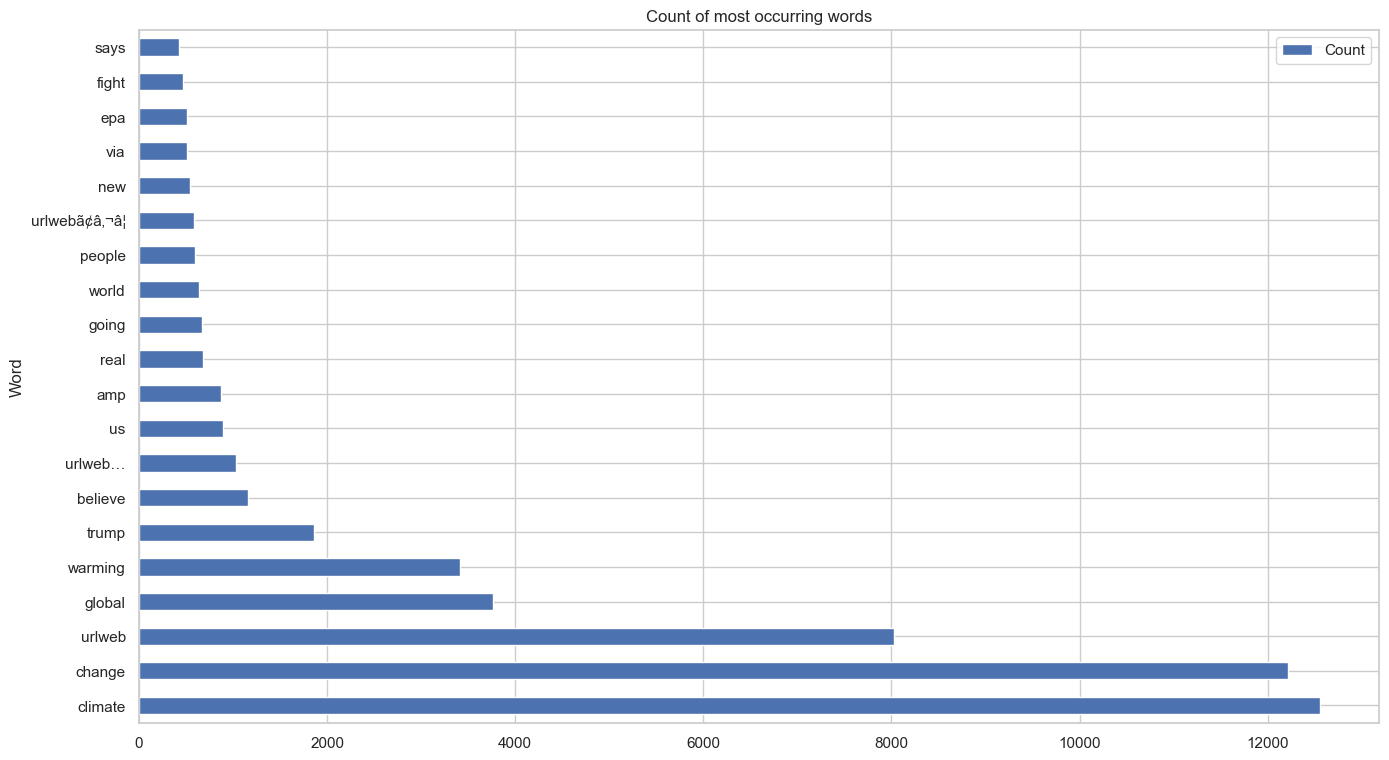

In [47]:
# Put word counts into dataframe
df_wordcount = pd.DataFrame(word_count, columns=["Word", "Count"])

# Select 15 most occurring words
df_to_plot = df_wordcount.head(20)

df_to_plot.plot(x="Word", kind='barh', title="Count of most occurring words", figsize=(16,9) )

From the above, we nota a few things: 

Most obviously, the most occuring word in the dataset is `climate`, followed closely by `change`. We see that other keywords such as `global` and `warming` also occurs very often, as does `trump`. 

Furthermore, we have a lot of links within the data. We see that we can improve on cleaning these links, since we see 3 categories of counts that all pertain to links posted. When training the model, we should attempt to remove more of the strange characters surrounding words

Let's investigate what words appear in the data only once:

In [48]:
# Amount of rare words
rare_words = df_wordcount[df_wordcount["Count"] == 1]
print(len(rare_words), " words appear only once in our data, which is ", round(len(rare_words)/len(word_count)*100, 2), "% of all words in the dataset")

# Print 100 examples of rare words
print(list(rare_words["Word"])[:100])

10842  words appear only once in our data, which is  56.97 % of all words in the dataset
['polyscimajor', 'lung', 'activistã¢â‚¬â¦', '8yo', 'nephew', 'inconsolable', 'perish', 'fiery', 'hellscape', 'offense…', 'like…', 'warming………', 'vocal', 'powering', '‘misled’', '����️��', 'zaynmalik', 'healthcare…', 'reunitingish', 'cast', 'rting', 'c40', '250m', 'michaels', 'vetted', 'bgr', 'aquifers', 'amts', '“unproven”', 'we’', 'dealt', 'protested', 'nba', 'finals', 'cronie', 'mph', 'charm', 'initially', 'thinked', 'europeaã¢â‚¬â¦', '🤦\u200d♂️', 'schwarzeneggers', 'maidillegal', 'cylinder', 'stratosphere', 'rpt', 'admins', 'jjxrry', 'quebanjesus', 'conditioner', 'icebreaking', 'opps', 'cv', 'environmentlondongovuk', 'energyenvt', 'refused', 'despit…', 'shake', 'sercs', 'roy', 'buzz', 'fertilization', 'automatic', 'specialist', 'air…', 'alleviating', 'epidemics', '“yet', 'lobbies', '500000', '“universities', 'geologist', 'syfys', 'incorporated', '02', 'trumpstersomg', 'trumpserst', 'idots', 'bas

Since these words constitutes a majority of our dataset, we should consider carefully if we keep them when training our models. By translating emojis and cleaning the data better, as well as applying stemming- or lemmatization techniques, we might be able to extract more valuable information from them.

_Include breakdown of most common words by category_

<a id="four"></a>
## 4. Data Engineering and NLP Preprocessing
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Data engineering ⚡ |
| :--------------------------- |
| In this section you are required to: clean the dataset, and possibly create new features - as identified in the EDA phase. |

---

To capture all the preprocessing happening within the data, we start a comet experiment:

In [49]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("Data Preprocessing")
experiment.set_name("Data Preprocessing")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/48f5773b6d354f2e81344bb24bb5fa86



First, to avoid duplicating the operations performed on both the testing and training dataset, we join them together:

In [50]:
# Discard all changes and reload the data
df_train = pd.read_csv('train.csv')
df_evaluate = pd.read_csv('test_with_no_labels.csv')

# Combine the training and testing data
df_combined = pd.concat((df_train, df_evaluate)) 


Next, let's extract the valuable features we identified:

In [51]:
# Get retweet status and handle
df_combined["is_retweet"] = df_combined["message"].apply(is_retweet, 1)
df_combined["retweet_handle"] =  df_combined["message"].apply(get_retweet, 1)

# Get hashtag count and extract hashtags
df_combined["hashtag_count"] = df_combined["message"].apply(count_hashtag, 1)
df_combined["hashtags"] =  df_combined["message"].apply(get_hashtag, 1)

# Get mention count and extract mentions
df_combined["mention_count"] = df_combined["message"].apply(count_mentions, 1)
df_combined["mentions"] =  df_combined["message"].apply(get_mentions, 1)

# Get number of links
df_combined["link_count"] = df_combined["message"].apply(count_links, 1)

# Get number of newlines
df_combined["newline_count"] = df_combined["message"].apply(enter_count, 1)

# Get number of exclamation marks
df_combined["exclamation_count"] =  df_combined["message"].apply(exclamation_count, 1)

df_combined.head()


sentiment                                            message  tweetid  \
0        1.0  PolySciMajor EPA chief doesn't think carbon di...   625221   
1        1.0  It's not like we lack evidence of anthropogeni...   126103   
2        2.0  RT @RawStory: Researchers say we have three ye...   698562   
3        1.0  #TodayinMaker# WIRED : 2016 was a pivotal year...   573736   
4        1.0  RT @SoyNovioDeTodas: It's 2016, and a racist, ...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

The next step, is to clean the message contained within the tweet. First, let's remove the retweet and mention handles, as well as the hashtags, since we have extracted that information already into their own features:

In [52]:
# Remove handles from tweet
df_combined["message"] = df_combined['message'].apply(remove_handles)
# Remove hashtags from tweet
df_combined["message"] = df_combined['message'].apply(remove_hashtags)
# Remove RT from tweet
df_combined["message"] = df_combined['message'].apply(remove_rt)

df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  PolySciMajor EPA chief doesn't think carbon di...   625221   
1        1.0  It's not like we lack evidence of anthropogeni...   126103   
2        2.0  Researchers say we have three years to act on ...   698562   
3        1.0  WIRED : 2016 was a pivotal year in the war on ...   573736   
4        1.0  It's 2016, and a racist, sexist, climate chang...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, we avoid duplicating words if they contain capitalization, by converting all characters in the tweet to lowercase:

In [53]:
# Convert tweet message to lowercase
df_combined["message"] = df_combined['message'].apply(lowercase)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief doesn't think carbon di...   625221   
1        1.0  it's not like we lack evidence of anthropogeni...   126103   
2        2.0  researchers say we have three years to act on ...   698562   
3        1.0  wired : 2016 was a pivotal year in the war on ...   573736   
4        1.0  it's 2016, and a racist, sexist, climate chang...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, we replace all contraction words with their constituent words (_eg: it's becomes it is_):

In [54]:
# Write function to replace contractions:
def fix_contractions(tweet):
    expanded_words = []
    for word in tweet.split():
        expanded_words.append(contractions.fix(word))
    
    returnstr = " ".join(expanded_words)
    return returnstr

# Apply function to tweet message:
df_combined["message"] = df_combined['message'].apply(fix_contractions)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief does not think carbon d...   625221   
1        1.0  it is not like we lack evidence of anthropogen...   126103   
2        2.0  researchers say we have three years to act on ...   698562   
3        1.0  wired : 2016 was a pivotal year in the war on ...   573736   
4        1.0  it is 2016, and a racist, sexist, climate chan...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, let's replace the URL links in our data with a alias in order to standardize them:

In [55]:
# Substitutes all URL links with url-web
pattern_url = r'http[s]?://(?:[A-Za-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9A-Fa-f][0-9A-Fa-f]))+'
subs_url = r'url-web'
df_combined['message'] = df_combined['message'].replace(to_replace = pattern_url, value = subs_url, regex = True)

Next, let's convert the emojis and emoticons present in our data to text: 

In [56]:
# Function to translate emojis and emoticons:
def fix_emojis(tweet):
    newtweet = emoji.demojize(tweet) # Translates 👍 emoji into a form like :thumbs_up: for example
    newtweet = newtweet.replace("_", " ") # Beneficial to split emoji text into multiple words
    newtweet = newtweet.replace(":", " ") # Separate emoji from rest of the words
    returntweet = newtweet.lower() # Make sure no capitalization sneaks in
    return returntweet

# Apply function to tweet message:
df_combined["message"] = df_combined['message'].apply(fix_emojis)

df_combined.head()       

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief does not think carbon d...   625221   
1        1.0  it is not like we lack evidence of anthropogen...   126103   
2        2.0  researchers say we have three years to act on ...   698562   
3        1.0  wired   2016 was a pivotal year in the war on ...   573736   
4        1.0  it is 2016, and a racist, sexist, climate chan...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Next, we remove common english stop words:

In [57]:
# Remove stop words from data
df_combined["message"] = df_combined['message'].apply(remove_stop_words)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief think carbon dioxide ma...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researchers say three years act climate change...   698562   
3        1.0  wired 2016 pivotal year war climate change url...   573736   
4        1.0  2016, racist, sexist, climate change denying b...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

We can also remove the strange characters in the data present as a result of encoding issues:

In [58]:
# Replace strange characters in data with closest ascii equivalent
def clean_tweet(tweet):
    # Normalize the tweet to remove diacritics and other special characters
    normalized_tweet = unicodedata.normalize('NFKD', tweet)
    
    # Remove or replace any remaining unwanted characters
    cleaned_tweet = normalized_tweet.encode('ascii', 'ignore').decode('utf-8')
    
    return cleaned_tweet.lower()

df_combined["message"] =df_combined['message'].apply(clean_tweet)

Let's remove the remaining punctuation:

In [59]:
# Remove remaining punctuation
df_combined["message"] =df_combined['message'].apply(remove_punctuation)


df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief think carbon dioxide ma...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researchers say three years act climate change...   698562   
3        1.0  wired 2016 pivotal year war climate change urlweb   573736   
4        1.0  2016 racist sexist climate change denying bigo...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

Let's also get rid of all numbers in the dataset, since they would contribute little to classifying the tweets:

In [60]:
# Function to remove numbers from tweet
def remove_numbers(tweet):
    return ''.join(char for char in tweet if not char.isdigit())

# Apply the function to the data
df_combined["message"] =df_combined['message'].apply(remove_numbers)

Next, let's lemmatize all of the words in contained in the message of the tweet. By doing so, we can group together word with similar meaning in order to help our model identify trends within the data 

In [61]:
# Create a lemmatizer object
lemmatizer = WordNetLemmatizer()

# Create function to lemmatize tweet content
def tweet_lemma(tweet, lemmatizer):
    list_of_lemmas = [lemmatizer.lemmatize(word) for word in tweet.split()] 
    return " ".join(list_of_lemmas) 

df_combined["message"] = df_combined["message"].apply(tweet_lemma, args=(lemmatizer, ))

df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  polyscimajor epa chief think carbon dioxide ma...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researcher say three year act climate change l...   698562   
3        1.0       wired pivotal year war climate change urlweb   573736   
4        1.0  racist sexist climate change denying bigot lea...   466954   

   is_retweet    retweet_handle  hashtag_count         hashtags  \
0           0                                0                    
1           0                                0                    
2           1         @RawStory              0                    
3           0                                1   #TodayinMaker#   
4           1  @SoyNovioDeTodas              1   #ElectionNight   

   mention_count    mentions  link_count  newline_count  exclamation_count  
0              1   @mashable           1              0                  1  
1              0                       0              0                  0  
2              0                       2              0                  0  
3              0                       1              0                  0  
4              0                       0              0                  0

We can improve our model performance and reduce training time by getting rid of words that only appears once in the dataset. These words won't help establish any connection between the tweet and the sentiment classes, since they appear only once, and no statistical significance can be drawn from them:

In [62]:
# Make dataframe of all word counts in the data
df_wordcounts = pd.DataFrame(df_combined['message'].str.split(expand=True).stack().value_counts())
df_wordcounts.reset_index(inplace=True)
df_wordcounts.rename(columns={"index": "word", 0:"count"}, inplace=True)

# Extract unique words from data
df_unique_words = df_wordcounts[df_wordcounts["count"]==1]
df_unique_words

# Investigate amount of unique words
print(len(df_unique_words), "out of", len(df_wordcounts), "words in our dataset appears only once, i.e.", str(round(len(df_unique_words)/len(df_wordcounts)*100, 2)) +"%", "of words used are unique")

# Make list of unique words
unique_wordlist = list(df_unique_words["word"])

# Function to remove unique words from data
def remove_unique_words(tweet):
    words = tweet.split()     
    return ' '.join([t for t in words if t not in unique_wordlist])

# Applying the function
df_combined["message"] =df_combined['message'].apply(remove_unique_words)

10836 out of 20072 words in our dataset appears only once, i.e. 53.99% of words used are unique


Now that our message is sufficiently clean, let's add our retweet handles, hashtags and mentions back into our text data, since they will be important to help distinguish between categories:

In [63]:
# Function to add retweets to message
def add_rt_handle(row):
    if row["retweet_handle"] == "":
        ret = row["message"]
    else:
        ret =  row["message"] + " rt_" + row["retweet_handle"]
    return ret
# Applying the function
df_combined["message"] = df_combined.apply(add_rt_handle, axis=1)

# Function to add retweets to message
def add_hashtag(row):
    if row["hashtags"] == "":
        ret = row["message"]
    else:
        ret =  row["message"] + " " + row["hashtags"]
    return ret
# Applying the function
df_combined["message"] = df_combined.apply(add_hashtag, axis=1)

# Function to add mentions to message
def add_rt_handle(row):
    if row["mentions"] == "":
        ret = row["message"]
    else:
        ret =  row["message"] + " " + row["mentions"]
    return ret
# Applying the function
df_combined["message"] = df_combined.apply(add_rt_handle, axis=1)



Dropping the redundant columns:

In [64]:
# Drop the specified columns
df_combined = df_combined.drop(["retweet_handle", "hashtags", "mentions"], axis=1)
df_combined.head()

sentiment                                            message  tweetid  \
0        1.0  epa chief think carbon dioxide main global war...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researcher say three year act climate change l...   698562   
3        1.0  wired pivotal year war climate change urlweb  ...   573736   
4        1.0  racist sexist climate change denying bigot lea...   466954   

   is_retweet  hashtag_count  mention_count  link_count  newline_count  \
0           0              0              1           1              0   
1           0              0              0           0              0   
2           1              0              0           2              0   
3           0              1              0           1              0   
4           1              1              0           0              0   

   exclamation_count  
0                  1  
1                  0  
2                  0  
3                  0  
4                  0

Finally, we can vectorise all the columns containing string data, i.e `message`, `retweet_handle`, `hashtags` and `mentions`. We will make use of the TfidfVectorizer module built into sklearn:

In [65]:
# # Initialize Vectorizer
tfid = TfidfVectorizer(ngram_range=(1,2) , max_features=MAX_TEXT_FEATURES) # Change max features to include more data

# Fit vectoriser on message data:
vec_message = tfid.fit_transform(df_combined["message"])



Converting our vectorized message to a dataframe to add to the other features:

In [66]:
sparse_vec_msg_df = pd.DataFrame.sparse.from_spmatrix(vec_message, columns = tfid.get_feature_names_out())

sparse_vec_msg_df.head()

100days  100days keepparis  100isnow  100percfedup  1010   1a  \
0      0.0                0.0       0.0           0.0   0.0  0.0   
1      0.0                0.0       0.0           0.0   0.0  0.0   
2      0.0                0.0       0.0           0.0   0.0  0.0   
3      0.0                0.0       0.0           0.0   0.0  0.0   
4      0.0                0.0       0.0           0.0   0.0  0.0   

   1followernodad  1o5c  1o5cleanenergy  1starfleetcadet  ...  zrastall17  \
0             0.0   0.0             0.0              0.0  ...         0.0   
1             0.0   0.0             0.0              0.0  ...         0.0   
2             0.0   0.0             0.0              0.0  ...         0.0   
3             0.0   0.0             0.0              0.0  ...         0.0   
4             0.0   0.0             0.0              0.0  ...         0.0   

   zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  zzzzaaaacccchhh  \
0        0.0        0.0       0.0               0.0    0.0              0.0   
1        0.0        0.0       0.0               0.0    0.0              0.0   
2        0.0        0.0       0.0               0.0    0.0              0.0   
3        0.0        0.0       0.0               0.0    0.0              0.0   
4        0.0        0.0       0.0               0.0    0.0              0.0   

    उत  उत तम_आह  तम_आह  
0  0.0       0.0    0.0  
1  0.0       0.0    0.0  
2  0.0       0.0    0.0  
3  0.0       0.0    0.0  
4  0.0       0.0    0.0  

[5 rows x 50000 columns]

Let' concatenate the numerical features with the newly preprocessed and vectorized text feature:

In [67]:
df_vectorized_combined = pd.concat([df_combined.reset_index(drop=True), sparse_vec_msg_df.reset_index(drop=True)], axis=1)
df_vectorized_combined.head()

sentiment                                            message  tweetid  \
0        1.0  epa chief think carbon dioxide main global war...   625221   
1        1.0    like lack evidence anthropogenic global warming   126103   
2        2.0  researcher say three year act climate change l...   698562   
3        1.0  wired pivotal year war climate change urlweb  ...   573736   
4        1.0  racist sexist climate change denying bigot lea...   466954   

   is_retweet  hashtag_count  mention_count  link_count  newline_count  \
0           0              0              1           1              0   
1           0              0              0           0              0   
2           1              0              0           2              0   
3           0              1              0           1              0   
4           1              1              0           0              0   

   exclamation_count  100days  ...  zrastall17  zsstevens  ztsamudzi  \
0                  1      0.0  ...         0.0        0.0        0.0   
1                  0      0.0  ...         0.0        0.0        0.0   
2                  0      0.0  ...         0.0        0.0        0.0   
3                  0      0.0  ...         0.0        0.0        0.0   
4                  0      0.0  ...         0.0        0.0        0.0   

   zwash300  zwash300 foxnews  zxkia  zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  
0       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
1       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
2       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
3       0.0               0.0    0.0              0.0  0.0       0.0    0.0  
4       0.0               0.0    0.0              0.0  0.0       0.0    0.0  

[5 rows x 50009 columns]

Since the message column has successfully been encoded, we can drop it from consideration:

In [68]:
df_vectorized_combined = df_vectorized_combined.drop("message", axis='columns')
df_vectorized_combined.head()

sentiment  tweetid  is_retweet  hashtag_count  mention_count  link_count  \
0        1.0   625221           0              0              1           1   
1        1.0   126103           0              0              0           0   
2        2.0   698562           1              0              0           2   
3        1.0   573736           0              1              0           1   
4        1.0   466954           1              1              0           0   

   newline_count  exclamation_count  100days  100days keepparis  ...  \
0              0                  1      0.0                0.0  ...   
1              0                  0      0.0                0.0  ...   
2              0                  0      0.0                0.0  ...   
3              0                  0      0.0                0.0  ...   
4              0                  0      0.0                0.0  ...   

   zrastall17  zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  \
0         0.0        0.0        0.0       0.0               0.0    0.0   
1         0.0        0.0        0.0       0.0               0.0    0.0   
2         0.0        0.0        0.0       0.0               0.0    0.0   
3         0.0        0.0        0.0       0.0               0.0    0.0   
4         0.0        0.0        0.0       0.0               0.0    0.0   

   zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  
0              0.0  0.0       0.0    0.0  
1              0.0  0.0       0.0    0.0  
2              0.0  0.0       0.0    0.0  
3              0.0  0.0       0.0    0.0  
4              0.0  0.0       0.0    0.0  

[5 rows x 50007 columns]

Let's move our target variable to the left most side of the dataframe for convenience:

In [69]:
# reindexing df so that our target variable is on the rightmost side:
df_vectorized_combined = df_vectorized_combined.reindex(columns = [col for col in df_vectorized_combined.columns if col != 'sentiment'] + ['sentiment'])
df_vectorized_combined.head()

tweetid  is_retweet  hashtag_count  mention_count  link_count  \
0   625221           0              0              1           1   
1   126103           0              0              0           0   
2   698562           1              0              0           2   
3   573736           0              1              0           1   
4   466954           1              1              0           0   

   newline_count  exclamation_count  100days  100days keepparis  100isnow  \
0              0                  1      0.0                0.0       0.0   
1              0                  0      0.0                0.0       0.0   
2              0                  0      0.0                0.0       0.0   
3              0                  0      0.0                0.0       0.0   
4              0                  0      0.0                0.0       0.0   

   ...  zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  \
0  ...        0.0        0.0       0.0               0.0    0.0   
1  ...        0.0        0.0       0.0               0.0    0.0   
2  ...        0.0        0.0       0.0               0.0    0.0   
3  ...        0.0        0.0       0.0               0.0    0.0   
4  ...        0.0        0.0       0.0               0.0    0.0   

   zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  sentiment  
0              0.0  0.0       0.0    0.0        1.0  
1              0.0  0.0       0.0    0.0        1.0  
2              0.0  0.0       0.0    0.0        2.0  
3              0.0  0.0       0.0    0.0        1.0  
4              0.0  0.0       0.0    0.0        1.0  

[5 rows x 50007 columns]

Let's split the data back into the respective training and evaluation datasets:

In [70]:
'''split data back into train and evaluation datasets: '''

# Extracting the response variables from the training dataset
y_train_dataset = df_vectorized_combined[:len(df_train)][['sentiment']]

# Separating predictor variables from response variable for the combined dataset
x_dataset = df_vectorized_combined[:len(df_vectorized_combined)].drop("sentiment", axis = "columns")

# Extracting predictor variables for the respective training and evaluation datasets 
x_train_dataset = df_vectorized_combined[:len(df_train)].drop('sentiment', axis='columns')
x_evaluate_dataset = df_vectorized_combined[len(df_train):].drop('sentiment', axis='columns')



The `tweet_id` column will not be used by the models, but will be necessary when we wish to evaluate our model performance in the competition, by using the *x_evaluate training set*. As such, let's save the `tweet_id`s in another dataframe for when we need to make a prediction submission, and drop the column from our training and evaluation datasets:

In [71]:
# Extract tweet id's that will be used when submitting predictions based on the evaluate dataset
df_tweetid_for_submission = pd.DataFrame(x_evaluate_dataset['tweetid'])
df_tweetid_for_submission

tweetid
15819   169760
15820    35326
15821   224985
15822   476263
15823   872928
...        ...
26360   895714
26361   875167
26362    78329
26363   867455
26364   470892

[10546 rows x 1 columns]

We can now safely drop this feature from consideration by our models:

In [72]:
# Remove tweet id form both testing and evaluation datasets
x_train_dataset = x_train_dataset.drop("tweetid", axis=1)
x_evaluate_dataset = x_evaluate_dataset.drop("tweetid", axis=1)

x_train_dataset.head()

is_retweet  hashtag_count  mention_count  link_count  newline_count  \
0           0              0              1           1              0   
1           0              0              0           0              0   
2           1              0              0           2              0   
3           0              1              0           1              0   
4           1              1              0           0              0   

   exclamation_count  100days  100days keepparis  100isnow  100percfedup  ...  \
0                  1      0.0                0.0       0.0           0.0  ...   
1                  0      0.0                0.0       0.0           0.0  ...   
2                  0      0.0                0.0       0.0           0.0  ...   
3                  0      0.0                0.0       0.0           0.0  ...   
4                  0      0.0                0.0       0.0           0.0  ...   

   zrastall17  zsstevens  ztsamudzi  zwash300  zwash300 foxnews  zxkia  \
0         0.0        0.0        0.0       0.0               0.0    0.0   
1         0.0        0.0        0.0       0.0               0.0    0.0   
2         0.0        0.0        0.0       0.0               0.0    0.0   
3         0.0        0.0        0.0       0.0               0.0    0.0   
4         0.0        0.0        0.0       0.0               0.0    0.0   

   zzzzaaaacccchhh   उत  उत तम_आह  तम_आह  
0              0.0  0.0       0.0    0.0  
1              0.0  0.0       0.0    0.0  
2              0.0  0.0       0.0    0.0  
3              0.0  0.0       0.0    0.0  
4              0.0  0.0       0.0    0.0  

[5 rows x 50005 columns]

Finally, we can split our overall training dataset into training and testing counterparts. The training subset will be used to train the model, while the testing subset will be used to test the preliminary model performance, and in doing so help with model optimization and hyperparameter tuning: 

In [73]:
X_train, X_test, y_train, y_test = train_test_split(x_train_dataset, y_train_dataset, test_size=TRAIN_TEST_SPLIT_VAR, random_state=RAND_STATE)

Ending the comet experiment for data preprocessing:

In [74]:
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/48f5773b6d354f2e81344bb24bb5fa86
COMET INFO:   Others:
COMET INFO:     Name : Data Preprocessing
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To 

<a id="five"></a>
## 5. Modelling
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Modelling ⚡ |
| :--------------------------- |
| In this section, you are required to create one or more regression models that are able to accurately predict the thee hour load shortfall. |

---

*Insert description about section, and maybe link to each subsection*

### 5.1 Logistic regression

*Insert brief explanation and model description*

In [75]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("LogisticRegression")
#experiment.set_name()

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/010d9e833b7f4f8db61ad6f088b2b87d



*Insert stuff*


In [76]:
# Train model

*Insert stuff*


In [77]:
# Test model on training subset

*Insert stuff*


In [78]:
# Perform hyperparameter tuning

*Insert stuff*


In [79]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [80]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [81]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [82]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [83]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/010d9e833b7f4f8db61ad6f088b2b87d
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the fo

*Discuss model, etc...*

### 5.2 Decision Tree

*Insert brief explanation and model description*

In [84]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("DecisionTree")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/a46f57618dc545fd9db7a415c3f95e19



*Insert stuff*


In [85]:
# Train model

*Insert stuff*


In [86]:
# Test model on training subset

*Insert stuff*


In [87]:
# Perform hyperparameter tuning

*Insert stuff*


In [88]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [89]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [90]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [91]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [92]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/a46f57618dc545fd9db7a415c3f95e19
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the fo

*Discuss model, etc...*

### 5.3 Random Forest

*Insert brief explanation and model description*

In [93]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("RandomForest")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/d5ec535f974044bf88d7bca328aedd6f



*Insert stuff*


In [94]:
# Train model

*Insert stuff*


In [95]:
# Test model on training subset

*Insert stuff*


In [96]:
# Perform hyperparameter tuning

*Insert stuff*


In [97]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [98]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [99]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [100]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [101]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/d5ec535f974044bf88d7bca328aedd6f
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the fo

*Discuss model, etc...*

### 5.4 Linear Support Vector

*Insert brief explanation and model description*

In [102]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("LinearSVC")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/2b6c353e8f494572adb236795afc182a



*Insert stuff*


In [103]:
# Train model

*Insert stuff*


In [104]:
# Test model on training subset

*Insert stuff*


In [105]:
# Perform hyperparameter tuning

*Insert stuff*


In [106]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [107]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [108]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [109]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [110]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/2b6c353e8f494572adb236795afc182a
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the fo

*Discuss model, etc...*

### 5.5 Radial Support Vector

*Insert brief explanation and model description*

In [111]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("RadialSVC")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/a80a3ff6e0c14a509c0087a8f9e4477f



*Insert stuff*


In [112]:
# Train model

*Insert stuff*


In [113]:
# Test model on training subset

*Insert stuff*


In [114]:
# Perform hyperparameter tuning

*Insert stuff*


In [115]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [116]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [117]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [118]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [119]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/a80a3ff6e0c14a509c0087a8f9e4477f
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the fo

*Discuss model, etc...*

### 5.6 Nearest Neighbor

*Insert brief explanation and model description*

In [120]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("NearestNeighbor")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/24cbc21f2947428689dd75d809ab5590



*Insert stuff*


In [121]:
# Train model

*Insert stuff*


In [122]:
# Test model on training subset

*Insert stuff*


In [123]:
# Perform hyperparameter tuning

*Insert stuff*


In [124]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [125]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [126]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [127]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [128]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/24cbc21f2947428689dd75d809ab5590
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the fo

*Discuss model, etc...*

### 5.7 Gaussian Naive Bayes

Gaussian Naive Bayes is a probabilistic classification model based on Bayes' theorem, which calculates the probability of a class given the input features. It assumes that the features are conditionally independent, meaning that the presence of one feature does not affect the presence of another feature. Despite this simplifying assumption, Gaussian Naive Bayes can be surprisingly effective in many real-world scenarios. It models the distribution of each class using a Gaussian (normal) distribution and calculates the probabilities using the feature values and their mean and standard deviation.

To predict the class of a new instance, the model computes the probability of each class based on the observed features and assigns the class with the highest probability as the predicted class. It achieves this by multiplying the probabilities of each feature value given the class and the prior probability of the class. This process is repeated for each class, and the class with the highest probability is chosen as the predicted class.

This model makes assumptions that simplifies the model, thereby increasing computational efficiency. It works well with small datasets, and usually requires very little training data. Even  though it assumes feature independency, it usually performs reasonably well if this assumption is violated to some extent. This is not always the case, however. If the model is presented with a lot of irrelevant or uncorrelated features, it can derail quickly, since it is very sensitive to both. Also, since this model is a relatively simple algorithm, it can perform worse than some of its more complex counterparts.

Lets begin our training process, by starting our Comet ML experiment, so that all aspects of the model gets logged for comparison:

In [129]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("GaussianNaiveBayes")
experiment.set_name("GaussianNaiveBayes")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/6fe797f8626d48ce84330b6042dff00d



We begin by initializing a Gaussian Naive Bayes classifier, and fitting it to the data:


In [130]:
# Creating a Gaussian Naive Bayes Classifier object:
gauss_nb = GaussianNB()

# Fitting the model to our training data subset
gauss_nb.fit(X_train, y_train)

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


GaussianNB()

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [131]:
# Predict values of the testing subset
pred_gauss_nb = gauss_nb.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_gauss_nb))

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.50      0.42      0.45       278
         0.0       0.42      0.34      0.38       425
         1.0       0.73      0.80      0.76      1755
         2.0       0.68      0.65      0.67       706

    accuracy                           0.67      3164
   macro avg       0.58      0.55      0.56      3164
weighted avg       0.66      0.67      0.66      3164



We see that our Gaussian Naive Bayes performs very poorly when trying to identify both the `Anti-climate change` and `Neutral about climate change` sentiments. It does capture `Pro-climate change` sentiments the best, and does reasonably well with `Factual news tweets`. This trend could very well be as a result of our imbalanced data, since the model conveniently performs best in the 2 categories most represented in the data. 

Let's see if we can improve our model by tuning some hyperparameters:


In [132]:
# Set hyper-parameters to tune (NB THIS WILL CHANGE DEPENDING ON THE MODEL USED. GOOGLE THE HYPERPARAMETERS TO TUNE FOR YOUR MODELS. IN THIS CASE< WE ONLY HAVE 1 NAMED var_smoothing, BUT IT IS POSSIBLE TO HAVE A LOT MORE)
gauss_nb_hyperparameters = {'var_smoothing': np.logspace(0,-9, num=8)} 

# Search over hyperparameter grid
gauss_nb_gridsearch = GridSearchCV(GaussianNB(), gauss_nb_hyperparameters, scoring='f1_weighted', cv =3, n_jobs=3) # This might be only f1 in your model if your model can handle multiclass classification. If not, leave it as f1_weighted

# Fit grid of models to the data
gauss_nb_gridsearch.fit(X_train, y_train)
gauss_nb_gridsearch.best_params_

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


{'var_smoothing': 3.727593720314938e-07}

After finding the optimal hyperparameter, we can see how our metrics are impacted:


In [133]:
# Get best predictor:
best_gauss_nb = gauss_nb_gridsearch.best_estimator_

# Use best estimator to make predictions
pred_best_gauss_nb = best_gauss_nb.predict(X_test)

# Print optimised classification report:
print(classification_report(y_test, pred_gauss_nb))

# Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
gauss_nb_cm = confusion_matrix(y_test, pred_best_gauss_nb)
gauss_nb_f1 = f1_score(y_test, pred_best_gauss_nb, average="weighted") # average only necessary if model nly deals in binary classification
gauss_nb_precision = precision_score(y_test, pred_best_gauss_nb, average='weighted')
gauss_nb_recall = recall_score(y_test, pred_best_gauss_nb, average="weighted")

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       0.50      0.42      0.45       278
         0.0       0.42      0.34      0.38       425
         1.0       0.73      0.80      0.76      1755
         2.0       0.68      0.65      0.67       706

    accuracy                           0.67      3164
   macro avg       0.58      0.55      0.56      3164
weighted avg       0.66      0.67      0.66      3164



We see that tuning the hyperparameters in this case, made no significant impact on the model performance. This model still struggles to predict categories that were underrepresented in the data


Next, we log the metrics calculated above to use within comet:


In [134]:
# Create logging info

# Add all relevant info pertaining to your model here
gauss_nb_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "Gauss_nb",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(gauss_nb_hyperparameters),
          "best_param": str(gauss_nb_gridsearch.best_params_),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": "TfidfVectorizer", # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR)# DO not remove this one
          }
gauss_nb_metrics = {"f1": gauss_nb_f1,
           "recall": gauss_nb_recall,
           "precision": gauss_nb_precision,
           "confusion_matrix": gauss_nb_cm
           }

# Log all important info
experiment.log_parameters(gauss_nb_params)
experiment.log_metrics(gauss_nb_metrics)

COMET WARNING: Cannot safely convert array([[ 123,   32,  115,    8],
       [  56,  147,  182,   40],
       [  57,  149, 1376,  173],
       [  11,   29,  203,  463]], dtype=int64) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


In [135]:
# Initiate final model
final_gauss_nb = GaussianNB( var_smoothing= 1.6378937069540613e-06) # Use determined hyperparameters here

# Train on all available data
final_gauss_nb.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
gauss_nb_kaggle_predictions = final_gauss_nb.predict(x_evaluate_dataset)


d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Finally, we produce a csv of the predictions to submit to Kaggle


In [136]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_gauss_nb_kaggle_predictions = pd.DataFrame(gauss_nb_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_gauss_nb_kaggle_predictions['sentiment'] = df_gauss_nb_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_gauss_nb_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_gauss_nb_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_gauss_nb_kaggle_submission.to_csv('Gaussian_Naive_Beyes_Predictions.csv', index=False)

df_gauss_nb_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714         -1
10542   875167          1
10543    78329          0
10544   867455          0
10545   470892          1

[10546 rows x 2 columns]

Finally, since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [137]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/6fe797f8626d48ce84330b6042dff00d
COMET INFO:   Metrics:
COMET INFO:     confusion_matrix : [[ 123   32  115    8]
 [  56  147  182   40]
 [  57  149 1376  173]
 [  11   29  203  463]]
COMET INFO:     f1               : 0.6607204452248044
COMET INFO:     precision        : 0.6569464370354045
COMET INFO:     recall           : 0.6665613147914032
COMET INFO:   Others:
COMET INFO:     Name : GaussianNaiveBayes
COMET INFO:   Parameters:
COMET INFO:     best_param         : {'var_smoothing': 3.727593720314938e-07}
COMET INFO:     model_type         : Gauss_nb
COMET INFO:     param_grid      

As we can see, this model might not particularly be suited to our data. This may be due to the fact that this is a simplified model sensitive to unimportant and correlated features. Our feature set is particularly large, containing many features that might be correlated, and even more that might not be strong indicators of prediction.

### 5.8 Multinomial Naive Bayes

Multinomial Naive Bayes is a variant of Naive Bayes that is specifically designed for classification tasks with discrete features. It is commonly used for text classification, where the input features are typically word frequencies or counts. Unlike Gaussian Naive Bayes, which assumes a Gaussian distribution for continuous features, Multinomial Naive Bayes assumes a multinomial distribution for discrete features.

In Multinomial Naive Bayes, the model learns the probability distribution of each feature given the class label. It estimates the probabilities using the training data, where the feature values represent the frequencies or counts of each feature in the documents of each class. To predict the class of a new instance, the model calculates the likelihood of observing the given feature values for each class and combines it with the prior probability of the class using Bayes' theorem. The class with the highest probability is chosen as the predicted class.

The key difference between this model, and the Gaussian Naive Bayes is in the assumptions made about the data. Multinomial Naive Bayes assumes a multinomial distribution for discrete features, whereas Gaussian Naive Bayes assumes a Gaussian distribution for continuous features. Multinomial Naive Bayes is appropriate for discrete features, such as word counts, while Gaussian Naive Bayes is suitable for continuous or normally distributed features.

This model is generally known to be efficient, even in large feature spaces. It also works well with unbalanced data, which is handy in our case. It is also able to handle multiclass classification problems, which our classification falls into. 

Let's start by initializing another Comet ML experiment, in order to log our model details for comparison:

In [138]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("MultinomialNaiveBayes")
experiment.set_name("MultinomialNaiveBayes")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.


COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/ee1c7c8e411b4e0e8822e52310d4e29d



We begin by initializing a Multinomial Naive Bayes classifier, and fitting it to the data:


In [139]:
# Creating a Multinomial Naive Bayes Classifier object:
multinom_nb = MultinomialNB()

# Fitting the model to our training data subset
multinom_nb.fit(X_train, y_train)

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


MultinomialNB()

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [140]:
# Predict values of the testing subset
pred_multinom_nb = multinom_nb.predict(X_test)

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_multinom_nb))

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       1.00      0.03      0.06       278
         0.0       1.00      0.04      0.08       425
         1.0       0.62      1.00      0.77      1755
         2.0       0.96      0.46      0.62       706

    accuracy                           0.66      3164
   macro avg       0.90      0.38      0.38      3164
weighted avg       0.78      0.66      0.58      3164



We see that as was the case for our Gaussian Naive Bayes, our Multinomial Naive Bayes also performs very poorly when trying to identify both the `Anti-climate change` and `Neutral about climate change` sentiments, scoring even lower in both _recall_ and _f1 score_. It does capture `Pro-climate change` sentiments the best, and does reasonably well with `Factual news tweets`. This trend could very well be as a result of our imbalanced data, since the model conveniently performs best in the 2 categories most represented in the data. It could also be as a result of our data being vectorised by using the TF-IDF Vectoriser, instead of using the counts of each word as our features.

Let's see if we can improve our model by tuning some hyperparameters:


In [141]:
# Set hyper-parameters to tune 
multinom_nb_hyperparameters = {'alpha': [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100,1000]} 

# Search over hyperparameter grid
multinom_nb_gridsearch = GridSearchCV(MultinomialNB(), multinom_nb_hyperparameters, scoring='f1',  cv =3, n_jobs=3) 

# Fit grid of models to the data
multinom_nb_gridsearch.fit(X_train, y_train)
multinom_nb_gridsearch.best_params_

d:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan]
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


{'alpha': 1e-05}

After finding the optimal hyperparameter, we can see how our metrics are impacted:


In [142]:
# Get best predictor:
best_multinom_nb = multinom_nb_gridsearch.best_estimator_

# Use best estimator to make predictions
pred_best_multinom_nb = best_multinom_nb.predict(X_test)

# Print optimised classification report:
print(classification_report(y_test, pred_multinom_nb))

# Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
multinom_nb_cm = confusion_matrix(y_test, pred_best_multinom_nb)
multinom_nb_f1 = f1_score(y_test, pred_best_multinom_nb, average="weighted" ) # average only necessary if model nly deals in binary classification
multinom_nb_precision = precision_score(y_test, pred_best_multinom_nb, average="weighted")
multinom_nb_recall = recall_score(y_test, pred_best_multinom_nb, average="weighted")

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       1.00      0.03      0.06       278
         0.0       1.00      0.04      0.08       425
         1.0       0.62      1.00      0.77      1755
         2.0       0.96      0.46      0.62       706

    accuracy                           0.66      3164
   macro avg       0.90      0.38      0.38      3164
weighted avg       0.78      0.66      0.58      3164



We see that tuning the hyperparameters in this case, made no significant impact on the model performance. This model still struggles to predict categories that were underrepresented in the data


Next, we log the metrics calculated above to use within comet:


In [143]:
# Create logging info

# Add all relevant info pertaining to your model here
multinom_nb_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "Multinomial_nb",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(multinom_nb_hyperparameters),
          "best_param": str(multinom_nb_gridsearch.best_params_),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": "TfidfVectorizer", # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR)# DO not remove this one
          }
multinom_nb_metrics = {"f1": multinom_nb_f1,
           "recall": multinom_nb_recall,
           "precision": multinom_nb_precision,
           "confusion_matrix": multinom_nb_cm
           }

# Log all important info
experiment.log_parameters(multinom_nb_params)
experiment.log_metrics(multinom_nb_metrics)

COMET WARNING: Cannot safely convert array([[ 137,   34,  100,    7],
       [  37,  164,  191,   33],
       [  44,  131, 1425,  155],
       [   9,   17,  169,  511]], dtype=int64) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


In [144]:
# Initiate final model
final_multinom_nb = MultinomialNB(alpha = 1e-05 ) # Use determined hyperparameters here

# Train on all available data
final_multinom_nb.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
multinom_nb_kaggle_predictions = final_multinom_nb.predict(x_evaluate_dataset)


d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


Finally, we produce a csv of the predictions to submit to Kaggle


In [145]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_multinom_nb_kaggle_predictions = pd.DataFrame(multinom_nb_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_multinom_nb_kaggle_predictions['sentiment'] = df_multinom_nb_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_multinom_nb_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_multinom_nb_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_multinom_nb_kaggle_submission.to_csv('Multinomial_Naive_Beyes_Predictions.csv', index=False)

df_multinom_nb_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          1

[10546 rows x 2 columns]

Finally, since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [146]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/ee1c7c8e411b4e0e8822e52310d4e29d
COMET INFO:   Metrics:
COMET INFO:     confusion_matrix : [[ 137   34  100    7]
 [  37  164  191   33]
 [  44  131 1425  155]
 [   9   17  169  511]]
COMET INFO:     f1               : 0.7006153403525458
COMET INFO:     precision        : 0.697518634740536
COMET INFO:     recall           : 0.7070164348925411
COMET INFO:   Others:
COMET INFO:     Name : MultinomialNaiveBayes
COMET INFO:   Parameters:
COMET INFO:     best_param         : {'alpha': 1e-05}
COMET INFO:     model_type         : Multinomial_nb
COMET INFO:     param_grid         : {'alpha': [

This model performs equally as well as the Gaussian Naive Beyes. It identifies our 2 most represented categories reasonably well, but struggles a lot to identify our other categories. 

### 5.9 Neural Network

*Insert brief explanation and model description*

In [147]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("NeuralNet")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/706427e7c5644e0f95dbcf3de0fe84cf



*Insert stuff*


In [148]:
# Train model

*Insert stuff*


In [149]:
# Test model on training subset

*Insert stuff*


In [150]:
# Perform hyperparameter tuning

*Insert stuff*


In [151]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [152]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [153]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [154]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [155]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/706427e7c5644e0f95dbcf3de0fe84cf
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get all data logged automatically, import comet_ml before the fo

*Discuss model, etc...*

### 5.10 CatBoost

CatBoost stands for Categorical Boosting and is a gradient boosting algorithm specifically designed to handle categorical features in classification tasks. It is an ensemble method that combines multiple weak predictive models, typically decision trees, to create a strong predictive model.
CatBoost incorporates several innovative techniques to handle categorical variables effectively. It can automatically handle categorical features without the need for manual preprocessing, as it uses an efficient algorithm to convert categorical features into numerical representations during the training process. This technique is known as "target encoding," where each category is encoded based on its relation to the target variable.

Furthermore, CatBoost employs gradient boosting, which iteratively builds an ensemble of decision trees by minimizing a loss function. It uses a unique method called "ordered boosting" that considers the order of categorical features during the tree building process. This helps capture the dependencies between categories, leading to improved predictive performance.

The CatBoost algorithm is effective in capturing complex interactions and non-linear interactions in the data, and is able to handle large datasets efficiently. It also supports parallelization to decrease training time. It is computationally expensive, however, especially when using a large number of trees or when complex datasets are involved. It also requires tuning of hyperparameters to achieve optimal performance.

It's worth noting that while CatBoost has its own unique features and strengths, it is part of the gradient boosting family of algorithms, sharing similarities with other boosting algorithms such as XGBoost and LightGBM.

As always, we start by initializing a comet experiment

In [156]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("CatBoost")
experiment.set_name("CatBoost")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/f3fc65d7534a4ae6a376a7d64803001b



In [157]:
y_train_boost = y_train.astype(int) +1
y_train_boost

sentiment
6735           2
13537          3
6876           2
10035          3
5174           1
...          ...
13418          2
5390           2
860            2
15795          3
7270           2

[12655 rows x 1 columns]

We can then initialize a CatBoost classifier, and fitting it to the data:


In [158]:
# Creating a CatBoost Classifier object:
catboost_classifier = CatBoostClassifier()

# Fitting the model to our training data subset
catboost_classifier.fit(X_train, y_train_boost)

d:\Anaconda\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.090061
0:	learn: 1.3238731	total: 466ms	remaining: 7m 45s
1:	learn: 1.2749742	total: 787ms	remaining: 6m 32s
2:	learn: 1.2329521	total: 1.11s	remaining: 6m 9s
3:	learn: 1.1982303	total: 1.43s	remaining: 5m 57s
4:	learn: 1.1696822	total: 1.75s	remaining: 5m 47s
5:	learn: 1.1460456	total: 2.06s	remaining: 5m 40s
6:	learn: 1.1250477	total: 2.38s	remaining: 5m 38s
7:	learn: 1.1049379	total: 2.71s	remaining: 5m 35s
8:	learn: 1.0915101	total: 3.02s	remaining: 5m 32s
9:	learn: 1.0795234	total: 3.34s	remaining: 5m 30s
10:	learn: 1.0648952	total: 3.67s	remaining: 5m 29s
11:	learn: 1.0540990	total: 3.99s	remaining: 5m 28s
12:	learn: 1.0457966	total: 4.31s	remaining: 5m 27s
13:	learn: 1.0373980	total: 4.64s	remaining: 5m 26s
14:	learn: 1.0297459	total: 4.96s	remaining: 5m 25s
15:	learn: 1.0231998	total: 5.28s	remaining: 5m 24s
16:	learn: 1.0150712	total: 5.59s	remaining: 5m 23s
17:	learn: 1.0086839	total: 5.92s	remaining: 5m 22s
18:	learn: 1.0036820	total: 6.23s	remaining: 

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [159]:
# Predict values of the testing subset
pred_catboost_classifier = catboost_classifier.predict(X_test)
pred_catboost_classifier = pred_catboost_classifier -1
# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_catboost_classifier))

              precision    recall  f1-score   support

        -1.0       0.80      0.26      0.39       278
         0.0       0.59      0.34      0.43       425
         1.0       0.70      0.86      0.78      1755
         2.0       0.70      0.67      0.69       706

    accuracy                           0.70      3164
   macro avg       0.70      0.53      0.57      3164
weighted avg       0.70      0.70      0.68      3164



We see a big improvement over the Naive Bayes models, not only in overall accuracy, but also for our individual underrepresented data categories. 


In [161]:
# Set hyper-parameters to tune 
catboost_classifier_hyperparameters = {
        'iterations': [500],
          'depth': [4, 6, 8, 10],
          # #'loss_function': ['Multiclass'],
          # 'l2_leaf_reg': np.logspace(-20, -19, 3),
          # 'leaf_estimation_iterations': [10],
          # 'logging_level':['Silent'],
          # 'random_seed': [RAND_STATE]
         }

# Search over hyperparameter grid
catboost_classifier_gridsearch = GridSearchCV(CatBoostClassifier(), catboost_classifier_hyperparameters, scoring='f1',  cv =3, n_jobs=3) 

# Fit grid of models to the data
catboost_classifier_gridsearch.fit(X_train, y_train_boost)
catboost_classifier_gridsearch.best_params_

d:\Anaconda\lib\site-packages\sklearn\model_selection\_search.py:952: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan]
  warnings.warn(
d:\Anaconda\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.161774
0:	learn: 1.2802372	total: 188ms	remaining: 1m 33s
1:	learn: 1.2107497	total: 342ms	remaining: 1m 25s
2:	learn: 1.1574071	total: 515ms	remaining: 1m 25s
3:	learn: 1.1228907	total: 675ms	remaining: 1m 23s
4:	learn: 1.0941844	total: 837ms	remaining: 1m 22s
5:	learn: 1.0677898	total: 995ms	remaining: 1m 21s
6:	learn: 1.0491348	total: 1.16s	remaining: 1m 22s
7:	learn: 1.0337959	total: 1.38s	remaining: 1m 24s
8:	learn: 1.0228282	total: 1.54s	remaining: 1m 24s
9:	learn: 1.0136337	total: 1.71s	remaining: 1m 24s
10:	learn: 1.0053652	total: 1.87s	remaining: 1m 23s
11:	learn: 0.9986791	total: 2.03s	remaining: 1m 22s
12:	learn: 0.9925902	total: 2.2s	remaining: 1m 22s
13:	learn: 0.9865385	total: 2.36s	remaining: 1m 22s
14:	learn: 0.9816430	total: 2.52s	remaining: 1m 21s
15:	learn: 0.9777321	total: 2.69s	remaining: 1m 21s
16:	learn: 0.9742354	total: 2.87s	remaining: 1m 21s
17:	learn: 0.9706026	total: 3.02s	remaining: 1m 20s
18:	learn: 0.9670538	total: 3.19s	remaining: 

{'depth': 4, 'iterations': 500}

After finding the optimal hyperparameter, we can see how our metrics are impacted:


In [162]:
# Get best predictor:
best_catboost_classifier = catboost_classifier_gridsearch.best_estimator_

# Use best estimator to make predictions
pred_best_catboost_classifier = best_catboost_classifier.predict(X_test)
pred_best_catboost_classifier = pred_best_catboost_classifier-1
# Print optimised classification report:
print(classification_report(y_test, pred_catboost_classifier))

# Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
catboost_classifier_cm = confusion_matrix(y_test, pred_best_catboost_classifier)
catboost_classifier_f1 = f1_score(y_test, pred_best_catboost_classifier, average="weighted" ) # average only necessary if model nly deals in binary classification
catboost_classifier_precision = precision_score(y_test, pred_best_catboost_classifier, average="weighted")
catboost_classifier_recall = recall_score(y_test, pred_best_catboost_classifier, average="weighted")

              precision    recall  f1-score   support

        -1.0       0.80      0.26      0.39       278
         0.0       0.59      0.34      0.43       425
         1.0       0.70      0.86      0.78      1755
         2.0       0.70      0.67      0.69       706

    accuracy                           0.70      3164
   macro avg       0.70      0.53      0.57      3164
weighted avg       0.70      0.70      0.68      3164



Tuning the hyperparameters.... __INSERT MORE!__

Next, we log the metrics calculated above to use within comet:


In [163]:
# Create logging info

# Add all relevant info pertaining to your model here
catboost_classifier_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "Catboost Classifier",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(catboost_classifier_hyperparameters),
          "best_param": str(catboost_classifier_gridsearch.best_params_),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": "TfidfVectorizer", # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR)# DO not remove this one
          }
catboost_classifier_metrics = {"f1": catboost_classifier_f1,
           "recall": catboost_classifier_recall,
           "precision": catboost_classifier_precision,
           "confusion_matrix": catboost_classifier_cm
           }

# Log all important info
experiment.log_parameters(catboost_classifier_params)
experiment.log_metrics(catboost_classifier_metrics)

COMET WARNING: Cannot safely convert array([[  69,   28,  165,   16],
       [   6,  133,  270,   16],
       [   8,   53, 1531,  163],
       [   1,    4,  231,  470]], dtype=int64) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


In [164]:
# Initiate final model
final_catboost_classifier = CatBoostClassifier(**catboost_classifier_gridsearch.best_params_) # Use determined hyperparameters here

# Train on all available data
final_catboost_classifier.fit(x_train_dataset, y_train_dataset)

# Generate predictions for the evaluation dataset
catboost_classifier_kaggle_predictions = final_catboost_classifier.predict(x_evaluate_dataset)
catboost_classifier_kaggle_predictions = catboost_classifier_kaggle_predictions 

d:\Anaconda\lib\site-packages\catboost\core.py:1411: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, embedding_features_data, pairs, weight,


Learning rate set to 0.163626
0:	learn: 1.2802797	total: 247ms	remaining: 2m 3s
1:	learn: 1.2052301	total: 529ms	remaining: 2m 11s
2:	learn: 1.1562946	total: 806ms	remaining: 2m 13s
3:	learn: 1.1200464	total: 1.06s	remaining: 2m 11s
4:	learn: 1.0864105	total: 1.35s	remaining: 2m 13s
5:	learn: 1.0643261	total: 1.7s	remaining: 2m 19s
6:	learn: 1.0454481	total: 2s	remaining: 2m 21s
7:	learn: 1.0328408	total: 2.37s	remaining: 2m 25s
8:	learn: 1.0194297	total: 2.74s	remaining: 2m 29s
9:	learn: 1.0088919	total: 3.05s	remaining: 2m 29s
10:	learn: 1.0022077	total: 3.34s	remaining: 2m 28s
11:	learn: 0.9953449	total: 3.64s	remaining: 2m 28s
12:	learn: 0.9896946	total: 3.98s	remaining: 2m 29s
13:	learn: 0.9853835	total: 4.28s	remaining: 2m 28s
14:	learn: 0.9795931	total: 4.56s	remaining: 2m 27s
15:	learn: 0.9747229	total: 4.89s	remaining: 2m 27s
16:	learn: 0.9706464	total: 5.19s	remaining: 2m 27s
17:	learn: 0.9671047	total: 5.49s	remaining: 2m 27s
18:	learn: 0.9643480	total: 5.79s	remaining: 2m 2

Finally, we produce a csv of the predictions to submit to Kaggle


In [165]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_catboost_classifier_kaggle_predictions = pd.DataFrame(catboost_classifier_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_catboost_classifier_kaggle_predictions['sentiment'] = df_catboost_classifier_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_catboost_classifier_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_catboost_classifier_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_catboost_classifier_kaggle_submission.to_csv('Catboost_Classifier_Predictions.csv', index=False)

df_catboost_classifier_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          1
10545   470892          1

[10546 rows x 2 columns]

Finally, since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [166]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/f3fc65d7534a4ae6a376a7d64803001b
COMET INFO:   Metrics:
COMET INFO:     confusion_matrix : [[  69   28  165   16]
 [   6  133  270   16]
 [   8   53 1531  163]
 [   1    4  231  470]]
COMET INFO:     f1               : 0.6718140191560953
COMET INFO:     precision        : 0.6983602221783587
COMET INFO:     recall           : 0.6962705436156763
COMET INFO:   Others:
COMET INFO:     Name : CatBoost
COMET INFO:   Parameters:
COMET INFO:     best_param         : {'depth': 4, 'iterations': 500}
COMET INFO:     model_type         : Catboost Classifier
COMET INFO:     param_grid         : {'i

__UPDATE ME__

### 5.11 XGBoost

XGBoost stands for Extreme Gradient Boosting and is a gradient boosting algorithm known for its high performance and accuracy in various machine learning tasks, including classification. It is an ensemble method that combines the predictions of multiple weak predictive models, usually decision trees, to create a strong predictive model.
XGBoost builds an ensemble of decision trees sequentially, where each new tree is trained to correct the mistakes made by the previous trees. It uses a gradient-based optimization technique to minimize a specific loss function, such as logistic loss for classification tasks. The algorithm calculates gradients and hessians to update the model parameters, ensuring that each subsequent tree focuses on the areas where the previous trees performed poorly.

Additionally, XGBoost incorporates several regularization techniques, such as shrinkage (learning rate) and tree pruning, to prevent overfitting and improve generalization. It also supports parallelization and distributed computing, making it efficient for training on large datasets.

XGBoost boasts exceptional predictive performance and accuracy, and is robust to outliers in the data. It also supports feature importance estimation, allowing for better understanding of feature contributions. It does however require careful hyperparameter tuning for optimal performance. It is also computationally intensive, especially with a large number of trees and complex datasets.

In [167]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("XGBoost")
experiment.set_name("XGBoost")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/a06ac58bccd74080af8c8b7b6b12deeb



We begin by initializing a XGBoost classifier, and fitting it to the data:


In [168]:
# Creating a XGBoost Classifier object:
xgb_classifier = XGBClassifier()

# Fitting the model to our training data subset
xgb_classifier.fit(X_train, y_train_boost)

KeyboardInterrupt: 

To get a sense of how well this model is performing, let's test the model on the testing subset of our training data:


In [ ]:
# Predict values of the testing subset
pred_xgb_classifier = xgb_classifier.predict(X_test)

pred_xgb_classifier = pred_xgb_classifier -1

# Let's produce a classification report of the model as is:
print(classification_report(y_test, pred_xgb_classifier))



              precision    recall  f1-score   support

        -1.0       0.78      0.29      0.43       278
         0.0       0.60      0.37      0.46       425
         1.0       0.72      0.85      0.78      1755
         2.0       0.71      0.72      0.71       706

    accuracy                           0.71      3164
   macro avg       0.70      0.56      0.60      3164
weighted avg       0.71      0.71      0.69      3164



__INSERT FEEDBACK HERE__

Let's see if we can improve our model by tuning some hyperparameters:


In [ ]:
# Set hyper-parameters to tune 
xgb_classifier_hyperparameters =  {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.01, 0.001],
    'subsample': [0.5, 0.7, 1]
} 

# Search over hyperparameter grid
xgb_classifier_gridsearch = GridSearchCV(XGBClassifier(), xgb_classifier_hyperparameters, scoring='f1',  cv =3, n_jobs=3) 

# Fit grid of models to the data
xgb_classifier_gridsearch.fit(X_train, y_train_boost)
xgb_classifier_gridsearch.best_params_

After finding the optimal hyperparameter, we can see how our metrics are impacted:


In [ ]:
# Get best predictor:
best_xgb_classifier = xgb_classifier_gridsearch.best_estimator_

# Use best estimator to make predictions
pred_best_xgb_classifier = best_xgb_classifier.predict(X_test)
pred_best_xgb_classifier = pred_best_xgb_classifier -1
# Print optimised classification report:
print(classification_report(y_test, pred_xgb_classifier))

# Produce confusion matrix, f1 score, precision and recall for model in order to log them to comet
xgb_classifier_cm = confusion_matrix(y_test, pred_best_xgb_classifier)
xgb_classifier_f1 = f1_score(y_test, pred_best_xgb_classifier, average="weighted" ) # average only necessary if model nly deals in binary classification
xgb_classifier_precision = precision_score(y_test, pred_best_xgb_classifier, average="weighted")
xgb_classifier_recall = recall_score(y_test, pred_best_xgb_classifier, average="weighted")

d:\Anaconda\lib\site-packages\sklearn\utils\validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


              precision    recall  f1-score   support

        -1.0       1.00      0.03      0.06       278
         0.0       1.00      0.04      0.08       425
         1.0       0.62      1.00      0.77      1755
         2.0       0.96      0.46      0.62       706

    accuracy                           0.66      3164
   macro avg       0.90      0.38      0.38      3164
weighted avg       0.78      0.66      0.58      3164



We see that tuning the hyperparameters in this case, made no significant impact on the model performance. This model still struggles to predict categories that were underrepresented in the data


Next, we log the metrics calculated above to use within comet:


In [ ]:
# Create logging info

# Add all relevant info pertaining to your model here
xgb_classifier_params = {"random_state": RAND_STATE, # DO not remove this one
          "model_type": "XGBoost Classifier",
          "scaler": "no scaling", # DO not remove this one
          "param_grid": str(xgb_classifier_hyperparameters),
          "best_param": str(xgb_classifier_gridsearch.best_params_),
          "text_feature_count": str(MAX_TEXT_FEATURES), # DO not remove this one
          "vectorizer": "TfidfVectorizer", # DO not remove this one
          "train_test_split": str(TRAIN_TEST_SPLIT_VAR)# DO not remove this one
          }
xgb_classifier_metrics = {"f1": xgb_classifier_f1,
           "recall": xgb_classifier_recall,
           "precision": xgb_classifier_precision,
           "confusion_matrix": xgb_classifier_cm
           }

# Log all important info
experiment.log_parameters(xgb_classifier_params)
experiment.log_metrics(xgb_classifier_metrics)

COMET WARNING: Cannot safely convert array([[ 137,   34,  100,    7],
       [  37,  164,  191,   33],
       [  44,  131, 1425,  155],
       [   9,   17,  169,  511]], dtype=int64) object to a scalar value, using its string representation for logging. Resulting string might be invalid


In order to produce a submission to Kaggle, we retrain the model using the optimised hyperparameters, and the complete set of training data:


In [ ]:
# Initiate final model
final_xgb_classifier = XGBClassifier(**xgb_classifier_gridsearch.best_params_ ) # Use determined hyperparameters here

# Train on all available data
y_train_boost_dataset = y_train_dataset.astype(int) +1
final_xgb_classifier.fit(x_train_dataset, y_train_boost_dataset)

# Generate predictions for the evaluation dataset
xgb_classifier_kaggle_predictions = final_xgb_classifier.predict(x_evaluate_dataset)
xgb_classifier_kaggle_predictions = xgb_classifier_kaggle_predictions -1

NameError: name 'XG' is not defined

Finally, we produce a csv of the predictions to submit to Kaggle


In [ ]:
# Produce kaggle submission csv 

# Make submissions into dataframe
df_xgb_classifier_kaggle_predictions = pd.DataFrame(xgb_classifier_kaggle_predictions, columns=["sentiment"])

# Convert sentiment to integer
df_xgb_classifier_kaggle_predictions['sentiment'] = df_xgb_classifier_kaggle_predictions['sentiment'].astype('int')

# Match submissions to tweet id's
df_xgb_classifier_kaggle_submission = pd.concat([df_tweetid_for_submission.reset_index(drop=True), df_xgb_classifier_kaggle_predictions.reset_index(drop=True)], axis=1,)


#Save submission as csv
df_xgb_classifier_kaggle_submission.to_csv('XGBoost_Classifier_Predictions.csv', index=False)

df_xgb_classifier_kaggle_submission

tweetid  sentiment
0       169760          1
1        35326          1
2       224985          1
3       476263          1
4       872928          0
...        ...        ...
10541   895714          1
10542   875167          1
10543    78329          2
10544   867455          0
10545   470892          1

[10546 rows x 2 columns]

Finally, since we are done with the model, we remember to end the experiment and write logs to Comet ML

In [ ]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/aa91cf5e99e24a1899049f3d0ff425ff
COMET INFO:   Metrics:
COMET INFO:     confusion_matrix : [[ 137   34  100    7]
 [  37  164  191   33]
 [  44  131 1425  155]
 [   9   17  169  511]]
COMET INFO:     f1               : 0.7006153403525458
COMET INFO:     precision        : 0.697518634740536
COMET INFO:     recall           : 0.7070164348925411
COMET INFO:   Others:
COMET INFO:     Name : MultinomialNaiveBayes
COMET INFO:   Parameters:
COMET INFO:     best_param         : {'alpha': 1e-05}
COMET INFO:     model_type         : Multinomial_nb
COMET INFO:     param_grid         : {'alpha': [

This model performs equally as well as the Gaussian Naive Beyes. It identifies our 2 most represented categories reasonably well, but struggles a lot to identify our other categories. 

*Insert stuff*


In [ ]:
# Train model

*Insert stuff*


In [ ]:
# Test model on training subset

*Insert stuff*


In [ ]:
# Perform hyperparameter tuning

*Insert stuff*


In [ ]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [ ]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [ ]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [ ]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [ ]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/9674625a60ba40d880614d5b1af01fcf
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (14.77 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get 

*Discuss model, etc...*

### 5.12 AdaBoost

*Insert brief explanation and model description*

In [ ]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("AdaBoost")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/6b5d298459834d87bbc22d836e57e0f9



*Insert stuff*


In [ ]:
# Train model

*Insert stuff*


In [ ]:
# Test model on training subset

*Insert stuff*


In [ ]:
# Perform hyperparameter tuning

*Insert stuff*


In [ ]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [ ]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [ ]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [ ]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [ ]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/6b5d298459834d87bbc22d836e57e0f9
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (14.77 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get 

*Discuss model, etc...*

### 5.13 Ensemble ...

*Insert brief explanation and model description*

In [ ]:
# Start comet experiment:
experiment = Experiment(
  api_key = "QZpbUKG0QUZWVVGESsEdeqX8f",
  project_name = "team-gm3-advanced-classification",
  workspace="kabous0017"
)

experiment.add_tag("Ensemble")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/kabous0017/team-gm3-advanced-classification/18fe67a33c364c30bc8b34ea82ffdbaa



*Insert stuff*


In [ ]:
# Train model

*Insert stuff*


In [ ]:
# Test model on training subset

*Insert stuff*


In [ ]:
# Perform hyperparameter tuning

*Insert stuff*


In [ ]:
# Produce confusion matrix, f1 score, precision and recall

# confusion_matrix(y_test, y_pred)))
# f1 = f1_score(y_test, y_pred)
# precision = precision_score(y_test, y_pred)
# recall = recall_score(y_test, y_pred)

*Insert stuff*


In [ ]:
# Log parameters and results

# params = {"random_state": 7,
#           "model_type": "logreg",
#           "scaler": "standard scaler",
#           "param_grid": str(param_grid),
#           "stratify": True
#           }
# metrics = {"f1": f1,
#            "recall": recall,
#            "precision": precision
#            }

# experiment.log_parameters(params)
# experiment.log_metrics(metrics)

*Insert stuff*


In [ ]:
# Retrain model using ALL of the original training data

*Insert stuff*


In [ ]:
# Produce kaggle submission csv (And remember to submit it to kaggle at least once)

*Insert stuff*


In [ ]:
# Ending the experiment
experiment.end()

COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/kabous0017/team-gm3-advanced-classification/18fe67a33c364c30bc8b34ea82ffdbaa
COMET INFO:   Uploads:
COMET INFO:     conda-environment-definition : 1
COMET INFO:     conda-info                   : 1
COMET INFO:     conda-specification          : 1
COMET INFO:     environment details          : 1
COMET INFO:     filename                     : 1
COMET INFO:     git metadata                 : 1
COMET INFO:     git-patch (uncompressed)     : 1 (14.77 MB)
COMET INFO:     installed packages           : 1
COMET INFO:     notebook                     : 1
COMET INFO:     source_code                  : 1
COMET INFO: 
COMET WARNING: To get 

*Discuss model, etc...*

<a id="six"></a>
## 6. Model Performance
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>

---
    
| ⚡ Description: Model performance ⚡ |
| :--------------------------- |
| In this section you are required to compare the relative performance of the various trained ML models on a holdout dataset and comment on what model is the best and why. |

---

In [ ]:
# Compare model performance

In [ ]:
# Choose best model and motivate why it is the best choice

<a id="seven"></a>
## 7. Appendix: Further optimization
<a class="anchor" id="1.1"></a>
<a href=#cont>Back to Table of Contents</a>



---

In [ ]:
# discuss chosen methods logic

100
